 - The first step is to read in the original data, the transformed data, and the residuals. 
 - We will predict the scaled, transformed data and the scaled residuals


In [105]:
data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
resid_file = 'environmental_residuals.txt'
txm_file = 'Transformed_WQVars_Hab_and_aDiv.txt'
orig_file = 'merged_paired_water_quality_data.txt'

resid_data <- as.data.frame(scale(read.delim(paste(data_dir, resid_file, sep="/"), row.names=1)))
txm_data <- read.delim(paste(data_dir, txm_file, sep="/"), row.names=1)
orig_data <- read.delim(paste(data_dir, orig_file, sep="/"), row.names=1)


apply(resid_data, MAR=2, FUN=mean)
apply(resid_data, MAR=2, FUN=sd)
apply(txm_data[,c('DO', 'PO4F', 'NO2F')], MAR=2, FUN=mean)
apply(txm_data[,c('DO', 'PO4F', 'NO2F')], MAR=2, FUN=sd)


NO2F_residuals PO4F_residuals   DO_residuals 
  3.599295e-17   6.644534e-18  -1.783815e-17

NO2F_residuals PO4F_residuals   DO_residuals 
             1              1              1

DO          PO4F          NO2F 
 1.368234e-16 -7.409448e-16  2.245070e-16

DO PO4F NO2F 
   1    1    1


  (-1,-0.5] (-0.5,0.25]  (0.25,0.5]  (0.5,0.85] (0.85,1.05] 
         49          28          44          52          63 

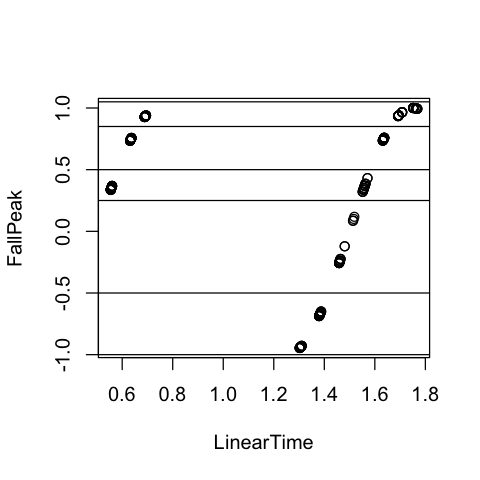

In [2]:
options(repr.plot.width=4, repr.plot.height=4)
with(orig_data, plot(LinearTime, FallPeak))
abline(h=c(1.05, 0.85, 0.5, 0.25, -0.5, -1))
table(cut(orig_data$FallPeak, c(1.05, 0.85, 0.5, 0.25, -0.5, -1)))

 - We will use the StatName and the binned seasonality data to create all possible combinations of time and location
 - We can pair each time x place with its opposite, because the response formed will be the same, with the 1s and 0s switched

Create all possible times and places

In [3]:
orig_data$seasonality = cut(orig_data$FallPeak, c(1.05, 0.85, 0.5, 0.25, -0.5, -1))
orig_data$seasonality = factor(as.integer(orig_data$seasonality))
table(orig_data$seasonality)

sample_times = base::sort(unique(orig_data$seasonality))

times_ = matrix(nrow = 5000, ncol = length(sample_times))
colnames(times_) <- paste('T', 1:length(sample_times), sep=".")
rownames(times_) <- paste('time', 1:5000, sep=".")

counter = 0
for (grp_size in 1:length(sample_times)){
    print(grp_size)
    grps = t(combn(sample_times, grp_size))
    print(dim(grps))
    for (row_n in 1:dim(grps)[1]){
        counter = counter + 1
        times_[counter,grps[row_n,]] = 1
    }
}

times_[is.na(times_)] = 0
times_ = times_[-which(rowSums(times_) == 0),]
dim(times_)

places = matrix(nrow = 5000, ncol = length(unique(txm_data$StatName)))
colnames(places) <- paste('P', 1:length(unique(txm_data$StatName)), sep=".")
rownames(places) <- paste('place', 1:5000, sep=".")


station_grps = base::sort(unique(txm_data$StatName))
counter = 0
for (grp_size in station_grps){
    print(grp_size)
    grps = t(combn(station_grps, grp_size))
    print(dim(grps))
    for (row_n in 1:dim(grps)[1]){
        counter = counter + 1
        places[counter,grps[row_n,]] = 1
    }
}

places[is.na(places)] = 0
places = places[-which(rowSums(places) == 0),]
dim(places)

times_places = matrix(nrow=nrow(places)*nrow(times_), 
                      ncol=ncol(places)+ncol(times_))

colnames(times_places) <- c(colnames(places), colnames(times_))
combo_rn = c()
combo_counter = 1
for (p_r in rownames(places)){
    for (t_r in rownames(times_)){
        combo_rn = c(combo_rn, paste(p_r, t_r, sep="_"))
        times_places[combo_counter, colnames(places)] = places[p_r,]
        times_places[combo_counter, colnames(times_)] = times_[t_r,]
        combo_counter = combo_counter + 1
    }
}
rownames(times_places) <- combo_rn
dim(times_places)
dim(unique(times_places))
old_names <- colnames(times_places)
times_places = cbind(times_places, apply(times_places, 1, paste, collapse=""), 
                     apply(abs(times_places - 1) , 1, paste, collapse=""))

colnames(times_places) <- c(old_names, 'binstring', 'opp.binstring')
head(times_places)


 1  2  3  4  5 
49 28 44 52 63 

[1] 1
[1] 5 1
[1] 2
[1] 10  2
[1] 3
[1] 10  3
[1] 4
[1] 5 4
[1] 5
[1] 1 5


[1] 31  5

[1] 1
[1] 7 1
[1] 2
[1] 21  2
[1] 3
[1] 35  3
[1] 4
[1] 35  4
[1] 5
[1] 21  5
[1] 6
[1] 7 6
[1] 7
[1] 1 7


[1] 127   7

[1] 3937   12

[1] 3937   12

,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5,binstring,opp.binstring
place.1_time.1,1,0,0,0,0,0,0,1,0,0,0,0,100000010000,011111101111
place.1_time.2,1,0,0,0,0,0,0,0,1,0,0,0,100000001000,011111110111
place.1_time.3,1,0,0,0,0,0,0,0,0,1,0,0,100000000100,011111111011
place.1_time.4,1,0,0,0,0,0,0,0,0,0,1,0,100000000010,011111111101
place.1_time.5,1,0,0,0,0,0,0,0,0,0,0,1,100000000001,011111111110
place.1_time.6,1,0,0,0,0,0,0,1,1,0,0,0,100000011000,011111100111


In [4]:
pair_list = list()
for (idx in 1:nrow(times_places)){
    t_p = rownames(times_places)[idx]
    animus = times_places[t_p, 'binstring']
    anima = times_places[, 'opp.binstring'] == animus
    if (sum(anima) > 0){
        p_t = names(which(anima))[1]
        doublet = sort(c(t_p, p_t))
        if (doublet[2] == t_p){
            pair_list[[idx]] = NA
        } else {
            pair_list[[idx]] = doublet[2]
        }
    } else {
        pair_list[[idx]] = 'unique'
    }
}

times_places = cbind(times_places, unlist(pair_list))
colnames(times_places)[colnames(times_places) == ''] <- 'setting_match'
length(which(times_places[,'setting_match'] == 'unique'))
sum(is.na(times_places[,'setting_match']))
head(times_places, 3)

[1] 157

[1] 1890

,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5,binstring,opp.binstring,setting_match
place.1_time.1,1,0,0,0,0,0,0,1,0,0,0,0,100000010000,011111101111,place.126_time.30
place.1_time.2,1,0,0,0,0,0,0,0,1,0,0,0,100000001000,011111110111,place.126_time.29
place.1_time.3,1,0,0,0,0,0,0,0,0,1,0,0,100000000100,011111111011,place.126_time.28


Here we take the columns that aren't NA from the above `time_place` object and create a matrix of binary responses. We also filter out any time/place combinations that have fewer than 12 supporting samples. This is because of our need to split the data into test/train sets (by a 3:1 ratio) to evaluate the model & the minimum of 8 samples per factor level for logisitc ridge regression. 

In [5]:
statN = length(unique(txm_data$StatName))
seasN = length(unique(orig_data$seasonality))
response_set = matrix(0, ncol=nrow(times_places), nrow=nrow(orig_data))
rownames(response_set) <- rownames(orig_data)
colnames(response_set) <- rownames(times_places)

for (t_p in rownames(times_places)){
    stat_bool = as.logical(as.integer(times_places[t_p,1:statN]))
    ssnlty_bool = as.logical(as.integer(times_places[t_p,(statN+1):(statN+seasN)]))
    accepted_statnames = (1:statN)[stat_bool]
    accepted_season = (1:seasN)[ssnlty_bool]
    ones_ = (orig_data$seasonality %in% accepted_season) & (txm_data$StatName %in% accepted_statnames)
    response_set[which(ones_), t_p] = 1
}
dim(response_set)
response_setx = response_set[,(colSums(response_set) > 12) & (colSums(response_set) < 224)]
dim(response_setx)
table(colSums(response_setx))

[1]  236 3937

[1]  236 3756


 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 
 24  37  38  37  28  43  44  36  39  38  39  48  51  31  39  50  41  45  53  41 
 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52 
 39  50  49  37  42  56  51  37  46  50  43  40  37  49  47  42  45  44  31  56 
 53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72 
 46  34  34  45  33  52  40  38  30  47  33  36  38  41  31  36  38  37  31  41 
 73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92 
 31  26  25  36  38  27  27  31  33  22  25  28  23  25  35  18  26  24  27  21 
 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 
 25  19  14  24  23  18  25  17  16  19  18  12  16  18  18  15  12  15  16  16 
113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
  8  12  18  14  10  11  11   8  14  14   6  11  10  12   5   6  10   5  12   8 
133 134 135 136 137 138 139

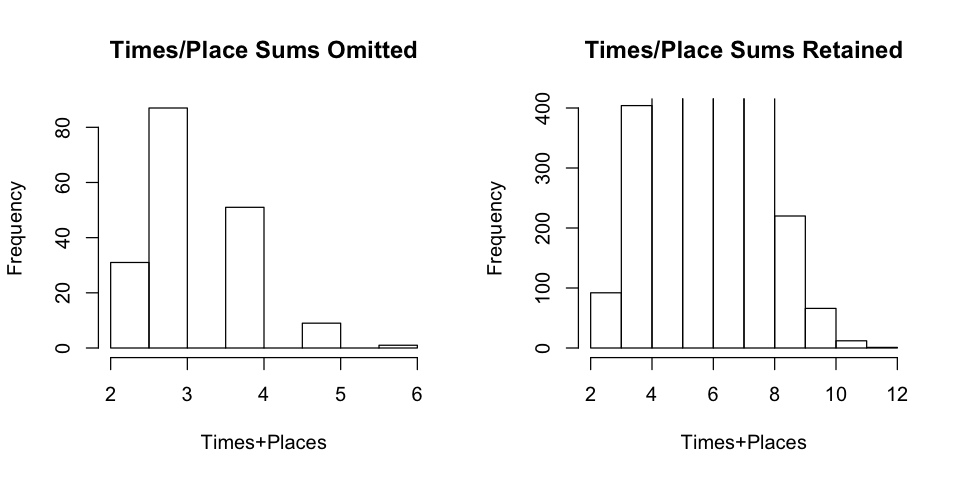

In [8]:
options(repr.plot.width=8, repr.plot.height=4)
tps_skipped = colnames(response_set)[colSums(response_set) <= 12]
tps_kept = colnames(response_set)[colSums(response_set) > 12]
par(mfrow=c(1,2))
hist(rowSums(apply(times_places[tps_skipped,1:12], MAR=2, as.integer)), xlab='Times+Places', 
     main='Times/Place Sums Omitted')
hist(rowSums(apply(times_places[tps_kept,1:12], MAR=2, as.integer)), xlab='Times+Places',
     ylim=c(0, 400), main='Times/Place Sums Retained')


Here's where we read in the abundance data and  create a place for the coefficients and run summary data

In [9]:
library(vegan)

rar_df = read.delim('../data/otu_tables/final_rarefied_table.tsv', row.names=1, sep="\t")[rownames(orig_data),]
rar_df = rar_df[which(rowSums(rar_df) > 0), which(colSums(rar_df) > 0)]
ra_rar_df = ((rar_df / rowSums(rar_df))*1e6)
dim(ra_rar_df)
int_rar_df = apply(apply(ra_rar_df, MAR=1, FUN=round), MAR=1, FUN=as.integer)
rownames(int_rar_df) <- rownames(ra_rar_df)
dim(int_rar_df)

coeff_cols = c('(Intercept)', colnames(ra_rar_df), 'coef.pos.n', 
               'coef.mean.n', 'ppv', 'npv', 'acc')
coeff_rows = colnames(response_setx)

fit_results = matrix(NA, ncol=length(coeff_cols), nrow=length(coeff_rows))
colnames(fit_results) <- coeff_cols
rownames(fit_results) <- coeff_rows

permutation2_results = fit_results
dim(permutation2_results)


Loading required package: permute
Loading required package: lattice
This is vegan 2.5-5


[1]  236 1432

[1]  236 1432

[1] 3756 1438

,otu,samples_occupied,maximum_abundance,spatial_range,seasonal_range,sites
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,OTU1,208,0.1872709,2.35303,1.945890,"1, 7, 6, 5, 4, 2, 3"
2,OTU2,123,0.2745751,2.35303,1.945890,"7, 5, 6, 4, 2, 3, 1"
3,OTU3,236,0.1542819,2.35303,1.945890,"1, 7, 6, 5, 4, 2, 3"
9,OTU10,199,0.1579474,2.35303,1.945342,"1, 7, 6, 5, 4, 2, 3"
12,OTU13,163,0.1692769,2.35303,1.940293,"1, 7, 6, 5, 4, 2, 3"
18,OTU21,159,0.2699100,2.23192,1.945890,"7, 6, 5, 4, 2, 3, 1"
338,OTU414,66,0.1512829,2.35303,1.945829,"7, 5, 6, 2, 3, 1, 4"
594,OTU764,8,0.1806065,1.03003,1.670142,"1, 2, 4"


,otu,samples_occupied,maximum_abundance,spatial_range,seasonal_range,sites
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1276,OTU2709,5,0.0023325558,0,0.6254526634,1
1179,OTU2075,2,0.0006664445,0,0.0001561936,1
1359,OTU3814,2,0.0029990003,0,0.0244898390,7
1366,OTU3975,2,0.0049983339,0,0.4052741723,1
1372,OTU4093,2,0.0039986671,0,0.1920595883,2
1421,OTU6605,2,0.0053315561,0,0.2781894053,1
1428,OTU8829,2,0.0036654449,0,0.0000000000,7
1430,OTU12431,2,0.0023325558,0,0.0000000000,7
339,OTU415,1,0.0129956681,0,0.0000000000,5


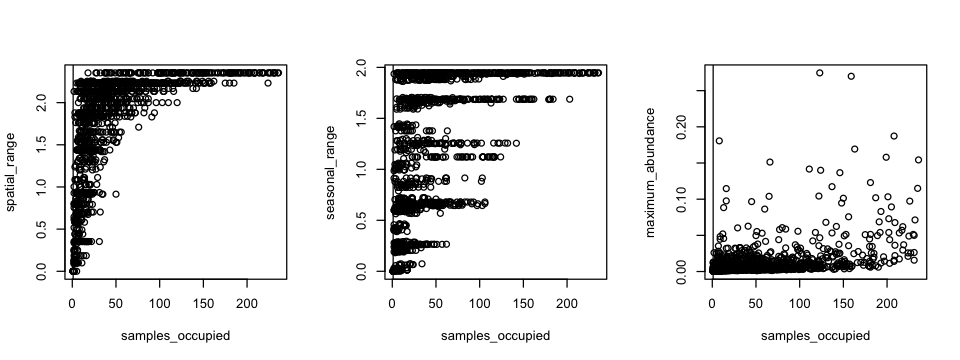

In [11]:
pfile2 = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/permuted_tablev2.txt'

if (file.exists(pfile2)) {
    perm_table2 = read.delim(pfile2, row.names=1)
    print('table 2 read')
    print(dim(perm_table2))
} else {
    perm_df2 = permatswap(int_rar_df, times=1)
    perm_table2 = perm_df2$perm[[1]]
    write.table(perm_table2, file=pfile2, sep="\t")
    print("table 2 written")
    print(dim(perm_table2))
}

[1] "table 2 read"
[1]  236 1432


In [12]:
library(caret)

coeff_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/timeplace_ridgeCoefficients.RData'

if (file.exists(coeff_file)) {
    load(coeff_file)
    print('Loaded coefficient results')
    predictor_sets = list('real'=log(ra_rar_df + 1), 'permat'=log(perm_table2 + 1 ))
} else {
    
    library(glmnet)
    library(doParallel)
    registerDoParallel(3)
    seed.counter = 0
    results_tables = list('real'=fit_results, 'permat'=permutation2_results)

    for (t_p in colnames(response_setx)) {
        # pull response
        response.j = factor(as.integer(response_setx[,t_p]))
        hits.j = which(response.j == 1)
        misses.j = which(response.j == 0)

        for (pred_name in names(predictor_sets)) {
            # pull & convert predictive matrix
            predictors.j = as.matrix(predictor_sets[[pred_name]])

            # set seed
            seed.counter = seed.counter + 1

            for (split.i in 1:5) {
                set.seed(seed.counter+split.i)
                # ensure splits include a minimum of 8 positive & negative results
                hits.ji = sample(hits.j, length(hits.j)*.75, rep=F)
                misses.ji = sample(misses.j, length(misses.j)*.75, rep=F)
                trainIxs = base::sort(c(hits.ji, misses.ji))
                predictors.ij = predictors.j[trainIxs,]
                response.ij = response.j[trainIxs]
                # pull out the test set by missing rownames
                testIxs = which(!(rownames(predictors.j) %in% rownames(predictors.ij)))
                predictors.ji = predictors.j[testIxs,]
                response.ji = response.j[testIxs]
                # fit model
                cvfit.ij <- cv.glmnet(x=predictors.ij, y=response.ij, family = "binomial", type.measure = "class",
                                     nfolds = 5, parallel = T)
                # predict on held out data
                fitted_values.ji = predict(cvfit.ij, newx=predictors.ji, type = "class", s = 'lambda.min')
                fitted_values.ji = factor(as.integer(as.numeric(fitted_values.ji)))
                # scores 1, 2, and 3 (it alwys assumes 'FALSE' and 0 are the positive class)
                cm.ij = confusionMatrix(factor(fitted_values.ji, levels=c(0, 1)), 
                                        factor(response.ji, levels=c(0, 1)), positive='1')
                coef.ij = as.matrix(coef(cvfit.ij, s = "lambda.min"))
                colnames(coef.ij) <- c(split.i)
                stats.ij = matrix(c(cm.ij$overall['Accuracy'], cm.ij$byClass['Pos Pred Value'], 
                                    cm.ij$byClass['Neg Pred Value']), ncol=1, nrow=3, 
                                  dimnames = list(c('acc', 'ppv', 'npv'), c(split.i)))
                if (split.i == 1) {
                    fold.scores = rbind(coef.ij, stats.ij)
                } else {
                    fold.scores = cbind(fold.scores, rbind(coef.ij, stats.ij))
                }
            }
            # average folds
            folded.scores = apply(fold.scores, 1, function(x) {mean(x, na.rm=T)})
            # pull out results recepticle 
            results.j = results_tables[[pred_name]]
            # add these scores
            results.j[t_p, 'acc'] = folded.scores['acc']
            results.j[t_p, 'ppv'] = folded.scores['ppv']
            results.j[t_p, 'npv'] = folded.scores['npv']
            # coefficients without score columns
            all_coeffs = folded.scores[1:(length(folded.scores)-3)]
            column_matcher = colnames(results.j)[which(colnames(results.j) %in% names(all_coeffs))]
            results.j[t_p, column_matcher] = folded.scores[column_matcher]
            # summary stats for just OTU coefficients
            just_otu_coeffs = folded.scores[2:(length(folded.scores)-3)]
            results.j[t_p, 'coef.pos.n'] = sum(just_otu_coeffs > 0)
            results.j[t_p, 'coef.mean.n'] = mean(just_otu_coeffs[just_otu_coeffs > 0])
            #repack results
            results_tables[[pred_name]] = results.j

            progpct = round(((seed.counter / (ncol(response_setx)*length(predictor_sets)))*100), 1)
            print(paste(t_p, pred_name, round(results.j[t_p, 'acc']*100, 1), progpct, collapse=", "))
            flush.console()
        }
    }

    stopImplicitCluster()
    save(results_tables, file=coeff_file)
    print('Saved result tables')
}

Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:vegan’:

    tolerance



[1] "Loaded coefficient results"


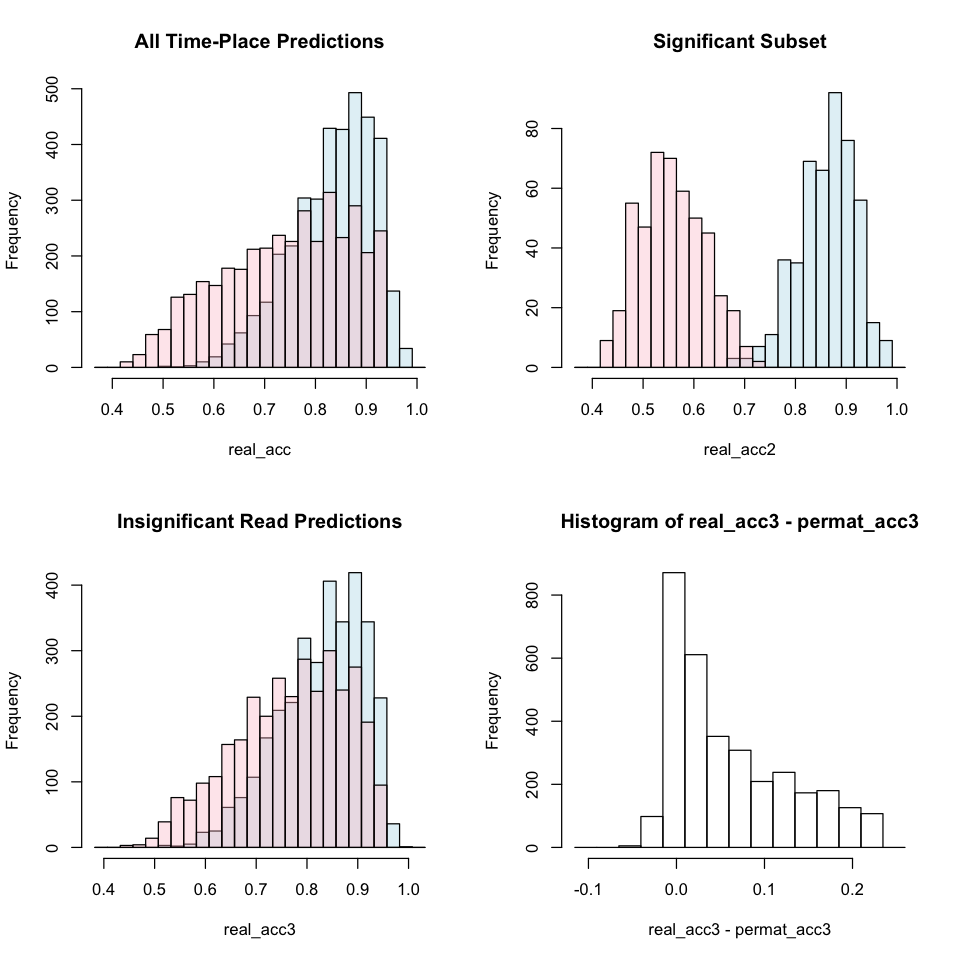

In [50]:
real_acc = results_tables[['real']][,'acc']
permat_acc = results_tables[['permat']][,'acc']
distsd = sd(c(real_acc, permat_acc))
distmean = mean(c(real_acc, permat_acc))
real_acc = (real_acc - distmean)
real_acc = (real_acc / distsd)
permat_acc = (permat_acc - distmean)
permat_acc = (permat_acc / distsd)
sig.diffs = which((real_acc-permat_acc) > 2)
in.sig.diffs = which((real_acc-permat_acc) <= 2)

real_acc2 = results_tables[['real']][sig.diffs,'acc']
permat_acc2 = results_tables[['permat']][sig.diffs,'acc']

real_acc3 = results_tables[['real']][in.sig.diffs,'acc']
permat_acc3 = results_tables[['permat']][in.sig.diffs,'acc']

real_acc = results_tables[['real']][,'acc']
permat_acc = results_tables[['permat']][,'acc']

options(repr.plot.width=8, repr.plot.height=8)
c1 <- rgb(173,216,230,max = 255, alpha = 90, names = "lt.blue")
c2 <- rgb(255,192,203, max = 255, alpha = 90, names = "lt.pink")

ax = seq(from=min(c(real_acc, permat_acc))-0.051, 
         to=max(c(real_acc, permat_acc))+0.051, by=0.025)
hgA_full <- hist(real_acc, breaks = ax, plot = FALSE) # Save first histogram data
hgB_full <- hist(permat_acc, breaks = ax, plot = FALSE) # Save 2nd histogram data

ax = seq(from=min(c(real_acc2, permat_acc2))-0.051, 
         to=max(c(real_acc2, permat_acc2))+0.051, by=0.025)
hgA_sig <- hist(real_acc2, breaks = ax, plot = FALSE) # Save first histogram data
hgB_sig <- hist(permat_acc2, breaks = ax, plot = FALSE) # Save 2nd histogram data

ax = seq(from=min(c(real_acc3, permat_acc3))-0.051, 
         to=max(c(real_acc3, permat_acc3))+0.051, by=0.025)
hgA_insig <- hist(real_acc3, breaks = ax, plot = FALSE) # Save first histogram data
hgB_insig <- hist(permat_acc3, breaks = ax, plot = FALSE) # Save 2nd histogram data

par(mfrow=c(2,2))
plot(hgA_full, col = c1, main='All Time-Place Predictions') # Plot 1st histogram using a transparent color
plot(hgB_full, col = c2, add = TRUE)     # Add 2nd histogram using different color

plot(hgA_sig, col = c1, main='Significant Subset') # Plot 1st histogram using a transparent color
plot(hgB_sig, col = c2, add = TRUE)     # Add 2nd histogram using different color

plot(hgA_insig, col = c1, main='Insignificant Read Predictions') # Plot 1st histogram using a transparent color
plot(hgB_insig, col = c2, add = TRUE)     # Add 2nd histogram using different color

ax = seq(from=min(real_acc3-permat_acc3)-0.051, 
         to=max(real_acc3-permat_acc3)+0.051, by=0.025)
hist(real_acc3-permat_acc3, breaks=ax, plot=T)


In [14]:
# add intra-cluster correlation, and cross-correlation with time and space 
old_cols = colnames(results_tables[['real']][sig.diffs, ])
sig_results = cbind(results_tables[['real']][sig.diffs, ], rep(NA, length(sig.diffs)),
                   rep(NA, length(sig.diffs)), rep(NA, length(sig.diffs)))
colnames(sig_results) <- c(old_cols, 'Intra.Group.Abund.Corr', 'Spatial.Corr', 'Seasonal.Corr')


for (sig_row in rownames(sig_results)){
    coef_row = sig_results[sig_row,colnames(ra_rar_df)]
    pos_coef = coef_row[coef_row > 0]
    subabund = ra_rar_df[,names(pos_coef)]
     subtimespace = orig_data[rownames(subabund),c('FallPeak', 'Latitude')]
    if (length(pos_coef) > 1){
        sig_results[sig_row, 'intra.cluster.corr'] = mean(as.dist(cor(subabund)))
        st_corr = apply(cor(x=subabund, y=subtimespace), 2, mean)
        sig_results[sig_row, 'space.corr'] = st_corr['Latitude']
        sig_results[sig_row, 'time.corr'] = st_corr['FallPeak']
    } else {
        print(c(sig_row, length(pos_coef)))
        flush.console()
    }
}


In [15]:
#options(repr.plot.width=8, repr.plot.height=3)
#par(mfrow=c(2,2))

# select significantly distinct time/places



[1] 0.3179916

,P.1,P.2,P.3,P.4,P.5,P.6,P.7
place.127,1,1,1,1,1,1,1
place.126,0,1,1,1,1,1,1
place.120,1,1,1,1,1,1,0
place.117,0,1,1,0,1,1,1
place.119,0,0,1,1,1,1,1
place.102,1,1,1,0,1,1,0
place.114,0,1,1,1,1,1,0
place.123,1,1,1,0,1,1,1


[1] 0.4979079

,T.1,T.2,T.3,T.4,T.5
time.25,0,0,1,1,1
time.26,1,1,1,1,0
time.21,1,0,0,1,1
time.30,0,1,1,1,1
time.20,1,0,1,0,1
time.18,1,1,0,0,1
time.19,1,0,1,1,0
time.24,0,1,0,1,1


[1] 400

,coef.pos.n,acc,ppv,npv,(Intercept),coef.mean.n,intra.cluster.corr,space.corr,time.corr,num.places,num.times,num.places.c,num.times.c
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
place.26_time.27,91,0.8745763,0.8039192,0.9265004,-2.1132078,0.04033477,0.03519101,-0.1476215,-0.03257729,2,4,#FF7F0E,#D62728
place.26_time.28,80,0.8779661,0.8284848,0.9136998,-0.6981330,0.02241775,0.04290172,-0.1357278,-0.01757481,2,4,#FF7F0E,#D62728
place.26_time.29,80,0.8433333,0.7930712,0.8850751,-0.8872793,0.02279268,0.04983153,-0.1716984,0.02156371,2,4,#FF7F0E,#D62728
place.26_time.30,80,0.8813559,0.8335137,0.9109806,-3.1764217,0.02717538,0.06488357,-0.1552849,0.12701469,2,4,#FF7F0E,#D62728
place.26_time.31,68,0.8366667,0.7964422,0.8833566,-0.3087634,0.01423918,0.04484662,-0.1699798,0.02199755,2,5,#FF7F0E,#9467BD
place.29_time.29,82,0.8933333,0.8934360,0.8947713,-0.4627523,0.03507609,0.07047887,0.2221640,0.06968744,3,4,#2CA02C,#D62728


Loading required package: carData


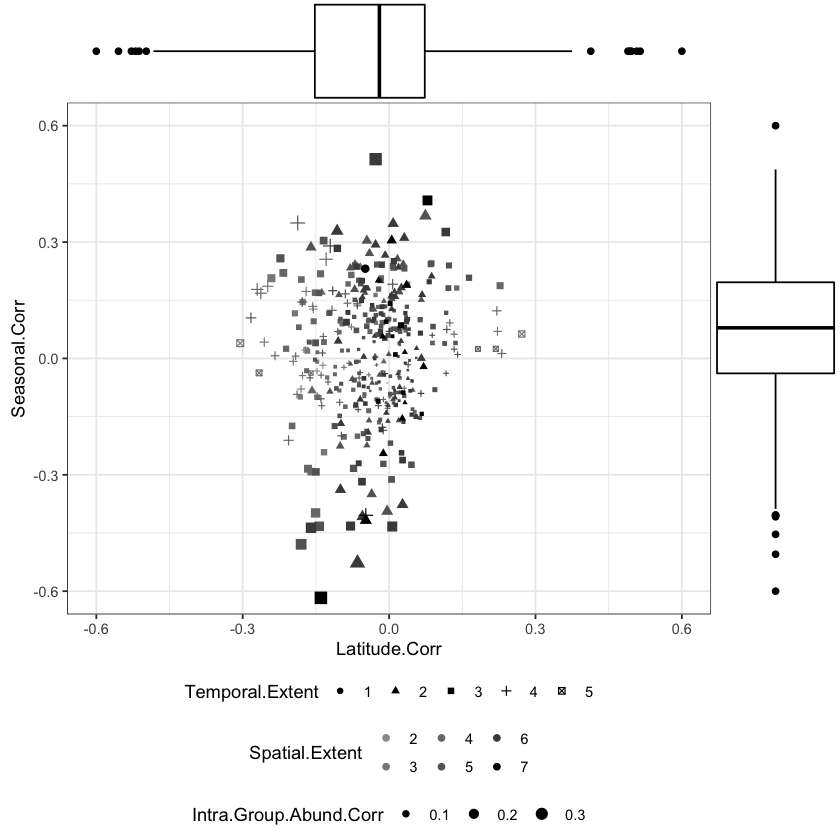

In [16]:
library(ggplot2)
library(ggExtra)

# select significantly distinct time/places
sig.tps = times_places[rownames(sig_results), 1:12]

# select perfect predictions including the first place
#best_rows1 = which((sig.tps[,1] == '1') & (sig_results[, 'acc'] == 1.))
best_rows1 = which((sig_results[, 'acc'] > 0.8))
length(best_rows1)
# get stats
stat.cols = c('coef.pos.n', 'acc', 'ppv', 'npv', '(Intercept)', 'coef.mean.n', 
              'intra.cluster.corr', 'space.corr', 'time.corr')
p1stats = as.data.frame(sig_results[best_rows1, stat.cols])

# add colors
p1stats = cbind.data.frame(p1stats, rowSums(apply(times_places[rownames(p1stats),1:7], 2, as.numeric)),
                           rowSums(apply(times_places[rownames(p1stats),8:12], 2, as.numeric)),
                           rep(NA, nrow(p1stats)), rep(NA, nrow(p1stats)))


color_cycle = c('#1F77B4', '#FF7F0E','#2CA02C', '#D62728', '#9467BD', '#8C564B',
               '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF')

colnames(p1stats) <- c(stat.cols, 'num.places', 'num.times', 'num.places.c', 'num.times.c')
for (dimcol in c('num.places', 'num.times')) {
    num_cats = length(unique(p1stats[,dimcol]))
    for (np in 1:num_cats){
        
        p1stats[which(p1stats[,dimcol] == as.character(np)), paste(dimcol, 'c', sep='.')] = color_cycle[np]
    }
}

# get places
p1defs = sig.tps[best_rows1,]

#p1coeffs = results_tables[['real']][p1, colnames(ra_rar_df)]

head(p1stats)
p1stats[is.na(p1stats[,'intra.cluster.corr']),'intra.cluster.corr'] <- min(p1stats[,'intra.cluster.corr'], na.rm=T)
p1stats[,'intra.cluster.corr'] <- p1stats[,'intra.cluster.corr'] + min(p1stats[,'intra.cluster.corr'])
p1stat_df = as.data.frame(p1stats)

#with(p1stat_df, symbols(x=space.corr, y=time.corr, circles=intra.cluster.corr, inches=0.1,
#                        ann=F, bg=num.places.c, fg=NULL, 
#                        main='Space:Time Correlations (colored by space coverage)'))

#with(p1stat_df, symbols(x=space.corr, y=time.corr, circles=intra.cluster.corr, inches=0.1,
#                        ann=F, bg=num.times.c, fg=NULL, 
#                        main='Space:Time Correlations (colored by time coverage)'))
options(repr.plot.width=7, repr.plot.height=7)
library(car)

p1stats[,'num.times'] <- factor(as.integer(p1stats[,'num.times']))
p1stats[,'num.places'] <- factor(as.integer(p1stats[,'num.places']))

colnames(p1stats)[colnames(p1stats) == 'space.corr'] = 'Latitude.Corr'
colnames(p1stats)[colnames(p1stats) == 'time.corr'] = 'Seasonal.Corr'
colnames(p1stats)[colnames(p1stats) == 'intra.cluster.corr'] = 'Intra.Group.Abund.Corr'
colnames(p1stats)[colnames(p1stats) == 'num.times'] = 'Temporal.Extent'
colnames(p1stats)[colnames(p1stats) == 'num.places'] = 'Spatial.Extent'

p1 <- ggplot(p1stats, aes(x=Latitude.Corr, y=Seasonal.Corr, 
                          color=Spatial.Extent, group=Temporal.Extent)) +
      geom_point(aes(size = Intra.Group.Abund.Corr, shape=Temporal.Extent)) + scale_size(range=c(0.0,3.2)) + 
      scale_colour_grey(start = 0.6, end = 0) + theme_bw() + coord_cartesian(xlim=c(-0.6, 0.6), ylim=c(-0.6, 0.6)) 

p1 <- p1 + theme(legend.position="bottom", legend.box="vertical", legend.margin=margin())

ggMarginal(p1, type="boxplot")


#bool2 = (p1stats[,'corr_score'] > 0.1)
#p1defs[bool2,]
#p1stats[bool2,]
#tail(p1stats[order(p1stats[,'(Intercept)']), ])
#tail(p1defs[order(p1stats[,'(Intercept)']), ])


In [17]:
cluster_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/oeu_clusters/cluster_assignments.txt'
cluster_vect = read.delim(cluster_file)
cluster_vect$asv.name <- rownames(cluster_vect)
cat(nrow(cluster_vect), " ", 'ASVs\n')
cluster_vect = cluster_vect[!is.na(cluster_vect$ward_clusters),]
cluster_df = data.frame(matrix(0, nrow=length(unique(cluster_vect$ward_clusters)), 
                               ncol=length(unique(cluster_vect$asv.name))))
colnames(cluster_df) <- unique(cluster_vect$asv.name)
rownames(cluster_df) <- unique(cluster_vect$ward_clusters)
for (r in rownames(cluster_df)){
    name_selector = which(cluster_vect$ward_clusters == r)
    cluster_df[r, cluster_vect[name_selector,'asv.name']] = 1
}

tp_coeffs = sig_results[,unique(cluster_vect$asv.name)]
tp_coeffs[tp_coeffs < 0 ] = 0
tp_coeffs[tp_coeffs > 0 ] = 1

oeu_memb_mat = as.matrix(cluster_df)
rownames(oeu_memb_mat) <- paste('OEU', rownames(oeu_memb_mat), sep=".")

tp_coeff_mat = as.matrix(tp_coeffs)
oeu_tpclust = t(cbind(t(oeu_memb_mat), t(tp_coeff_mat)))

tp_containment = matrix(0, nrow=nrow(tp_coeffs), ncol=nrow(oeu_memb_mat))
rownames(tp_containment)<- rownames(tp_coeffs)
colnames(tp_containment) <- rownames(oeu_memb_mat)

for (tp in rownames(tp_containment)){
    otus_in_tp = colnames(tp_coeff_mat)[which(tp_coeff_mat[tp,] > 0)]
    for (oeu in colnames(tp_containment)){
        otus_in_oeu = colnames(oeu_memb_mat)[which(oeu_memb_mat[oeu,] > 0)]
        tp_containment[tp, oeu] = length(which(otus_in_oeu %in% otus_in_tp)) / length(otus_in_oeu)
    }
}
tp_containment[ tp_containment < 0.66 ] = 0 
tp_containment_total = base::sort(rowSums(tp_containment), decreasing=T)

1432   ASVs


,T.1,T.2,T.3,T.4,T.5
place.98_time.25,0,0,1,1,1
place.97_time.30,0,1,1,1,1
place.117_time.6,1,1,0,0,0
place.117_time.25,0,0,1,1,1
place.127_time.15,0,0,0,1,1
place.120_time.15,0,0,0,1,1
place.124_time.16,1,1,1,0,0
place.63_time.30,0,1,1,1,1
place.97_time.16,1,1,1,0,0
place.119_time.16,1,1,1,0,0


[1] "Station"                        "OLD_DATE_TIME"                 
 [3] "OldDepth"                       "qPCR.ct"                       
 [5] "CollectionAgency"               "sequencing_ID"                 
 [7] "TrimCount"                      "TotalDepth"                    
 [9] "PctTotalDepth"                  "WaterColumnPosition"           
[11] "cruise_id"                      "SampleDate"                    
[13] "Depth"                          "PHEO"                          
[15] "TN"                             "TP"                            
[17] "CHLA"                           "DOP"                           
[19] "DON"                            "NH4F"                          
[21] "NO2F"                           "NO3F"                          
[23] "PC"                             "PO4F"                          
[25] "DO"                             "PH"                            
[27] "SALINITY"                       "WTEMP"                         
[29] "LinearTime"                     "DayLength"                     
[31] "FallPeak"                       "SpringPeak"                    
[33] "Discharge_Rappahannock.instant" "Discharge_Rappahannock.15"     
[35] "Discharge_Rappahannock.30"      "Discharge_Rappahannock.60"     
[37] "Discharge_Potomac.instant"      "Discharge_Potomac.15"          
[39] "Discharge_Potomac.30"           "Discharge_Potomac.60"          
[41] "Discharge_Susquehanna.instant"  "Discharge_Susquehanna.15"      
[43] "Discharge_Susquehanna.30"       "Discharge_Susquehanna.60"      
[45] "interpolated_CHLA.instant"      "interpolated_CHLA.15"          
[47] "interpolated_CHLA.30"           "interpolated_CHLA.60"          
[49] "measurement_PAR.instant"        "measurement_PAR.15"            
[51] "measurement_PAR.30"             "measurement_PAR.60"            
[53] "WIND_RATIO_BWI.instant"         "WIND_RATIO_BWI.15"             
[55] "WIND_RATIO_BWI.30"              "WIND_RATIO_BWI.60"             
[57] "PRECIP24HR_BWI.instant"         "PRECIP24HR_BWI.15"             
[59] "PRECIP24HR_BWI.30"              "PRECIP24HR_BWI.60"             
[61] "Discharge_Sum.instant"          "Discharge_Sum.15"              
[63] "Discharge_Sum.30"               "Discharge_Sum.60"              
[65] "Latitude"                       "Longitude"                     
[67] "seasonality"

StationGroup,Latitude.min,Latitude.max
<int>,<dbl>,<dbl>
1,39.24950,39.34873
2,38.64618,39.16369
3,38.41457,38.55505
4,38.13705,38.31870
5,37.68346,37.91011
6,37.41153,37.58847
7,36.99570,37.23653


StationGroup,Seasonal.min,Seasonal.max
<fct>,<dbl>,<dbl>
1,-0.9459381,-0.6500387
2,-0.2575024,0.1177867
3,0.3203978,0.4314604
4,0.7344523,0.7589990
5,0.9267713,0.9999517


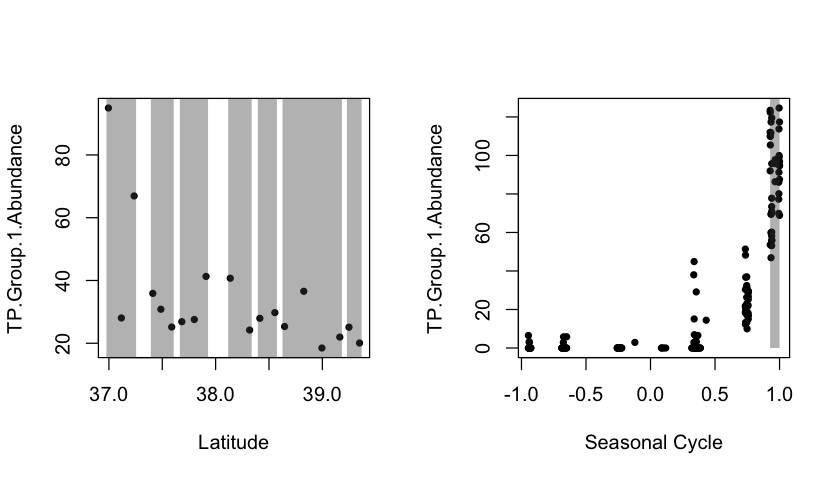

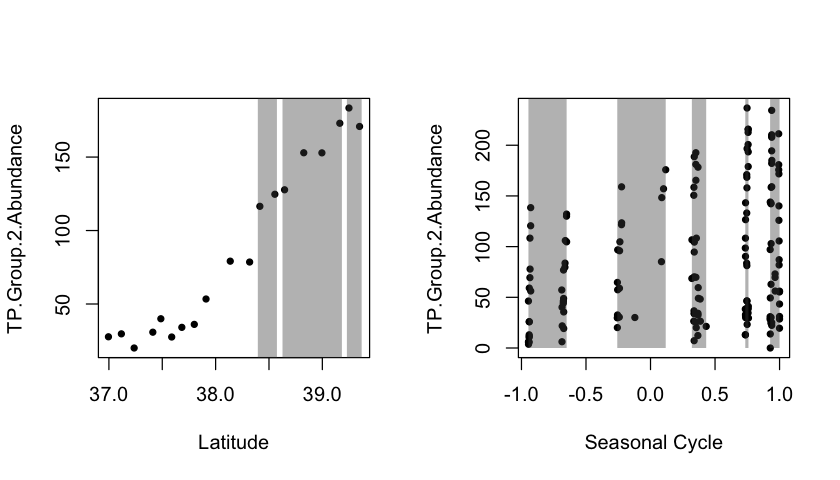

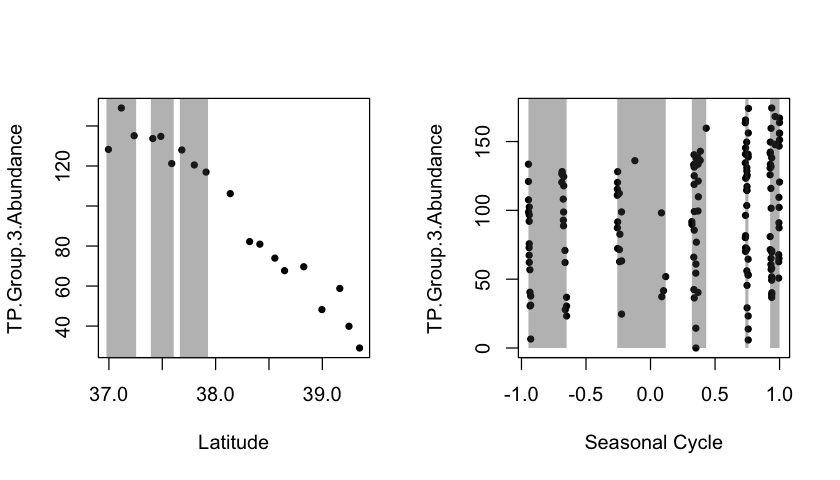

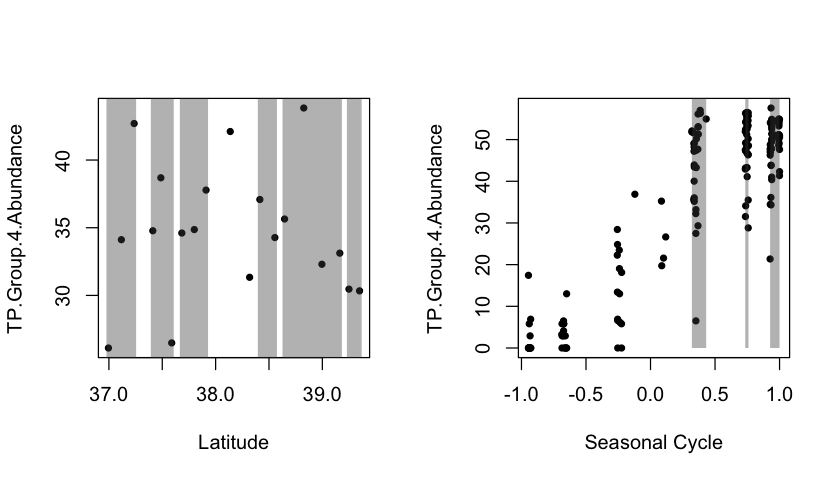

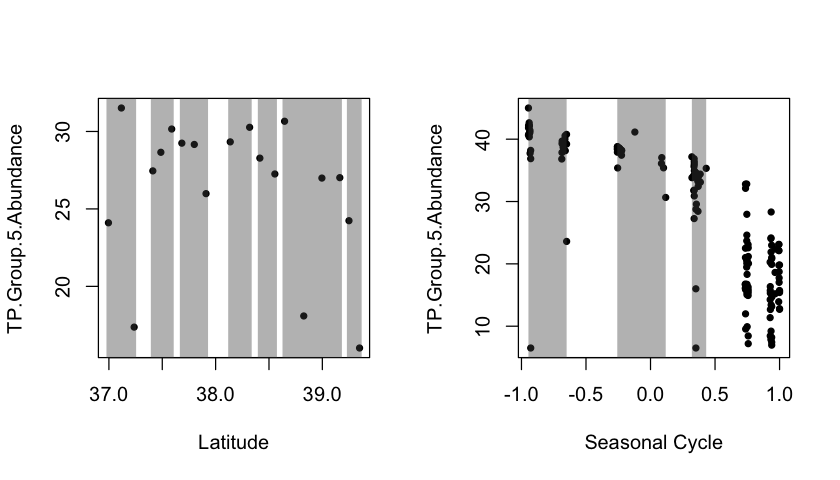

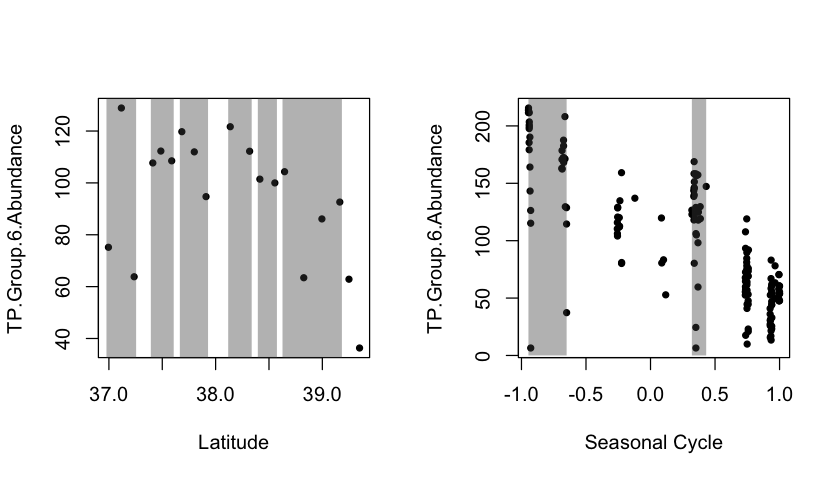

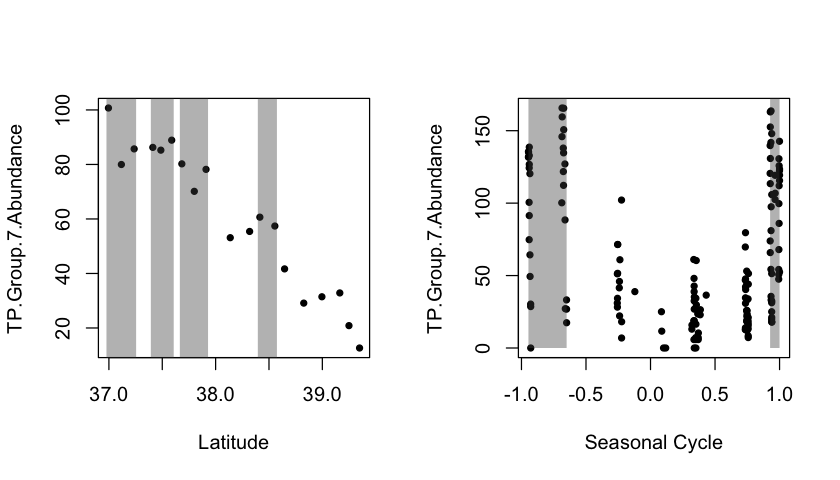

In [20]:


best_tps = rownames(p1stats)[unique(c(spacetime1, spacetime2, spacetime3, spacetime4, spacetime5, spacetime6))]
best_tps = c(best_tps, 'place.126_time.7', 'place.97_time.9')
p1stats2 = cbind.data.frame(p1stats, tp_containment_total[rownames(p1stats)])
colnames(p1stats2) <- c(colnames(p1stats), 'OEUs.contained')

sorted_samples = rownames(orig_data[with(orig_data, order(cruise_id, Station)),])

for (tp_idx in 1:length(best_tps)){
    this_tp = best_tps[tp_idx]
    best_set = sig_results[this_tp, colnames(ra_rar_df)]
    otus_in_bs = colnames(ra_rar_df)[which(best_set > 0)]
    abunds_bs = rowSums(predictor_sets[['real']][sorted_samples, otus_in_bs])
    aggabunds = cbind(abunds_bs, orig_data[sorted_samples, 'Latitude'])
    colnames(aggabunds) <- c(this_tp, 'Latitude')
    aggspace <- aggregate(aggabunds, by=list(aggabunds[,'Latitude']), FUN=mean)
    aggabunds = cbind(abunds_bs, orig_data[sorted_samples, 'FallPeak'])
    colnames(aggabunds) <- c(this_tp, 'Seasonality')
    aggtime <- aggregate(aggabunds, by=list(aggabunds[,'Seasonality']), FUN=mean)

    options(repr.plot.width=7, repr.plot.height=4)
    par(mfrow=c(1,2))
    plot(aggspace[, 'Latitude'], aggspace[, this_tp], pch=20, xlab='Latitude', 
         ylab=paste("TP.Group", tp_idx, 'Abundance',  sep="."))
    sublat = stat_lat[which(stat_lat[,1] %in% which(sig.tps[this_tp,1:7] == '1')),]
    for (r in 1:nrow(sublat)){
        latbox = c(sublat[r,c(2)]*0.9995, sublat[r,c(3)]*1.0005, sublat[r,c(3)]*1.0005, sublat[r,c(2)]*0.9995)
        abundbox1 = c(0, 0, max(aggspace[, this_tp])*1.2, max(aggspace[, this_tp])*1.2)
        polygon(x=latbox, y=abundbox1, col=rgb(.3,.3,.3,max=1,alpha=0.4), border=NA)
    }

    plot(aggtime[, 'Seasonality'], aggtime[, this_tp], pch=20, xlab='Seasonal Cycle', 
         ylab=paste("TP.Group", tp_idx, 'Abundance',  sep="."))
    subseas = seas_fp[which(seas_fp[,1] %in% which(sig.tps[this_tp,8:12] == '1')),]
    for (r in 1:nrow(subseas)){
        seasbox = c(subseas[r,c(2)], subseas[r,c(3)], subseas[r,c(3)], subseas[r,c(2)])
        abundbox2 = c(0, 0, max(aggtime[, this_tp])*1.2, max(aggtime[, this_tp])*1.2)
        polygon(x=seasbox, y=abundbox2, col=rgb(.3,.3,.3,max=1,alpha=0.4), border=NA)
    }
}

In [30]:
# check for bloom events 
pa_df = (int_rar_df > 1)
site_occupancy = colSums(apply(pa_df, MAR=2, as.integer))
single_sample_occupants = names(site_occupancy)[site_occupancy < 250]
bloom_candidates = data.frame('otu'=single_sample_occupants)
bloom_candidates[,'samples_occupied'] <- NA
bloom_candidates[,'maximum_abundance'] <- NA
bloom_candidates[,'spatial_range'] <- NA
bloom_candidates[,'seasonal_range'] <- NA
bloom_candidates[,'sites'] <- NA

for (otu in single_sample_occupants){
    rowsel = which(bloom_candidates[,'otu'] == otu)
    sitesel = which(int_rar_df[,otu] > 0)
    site_names = rownames(int_rar_df)[sitesel]
    bloom_candidates[rowsel,'samples_occupied'] = length(sitesel)
    bloom_candidates[rowsel,'maximum_abundance'] = max(ra_rar_df[site_names, otu] / 1e6)
    bloom_candidates[rowsel,'spatial_range'] = max(orig_data[site_names, 'Latitude']) - min(orig_data[site_names, 'Latitude'])
    bloom_candidates[rowsel,'seasonal_range'] = max(orig_data[site_names, 'FallPeak']) - min(orig_data[site_names, 'FallPeak'])
    bloom_candidates[rowsel,'sites'] = paste(unique(txm_data[site_names, 'StatName']), collapse=", ")
}

bloom_candidates[which(bloom_candidates[,'maximum_abundance'] > 0.15),]

options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))
with(bloom_candidates, plot(samples_occupied, spatial_range))
abline(v=1)
with(bloom_candidates, plot(samples_occupied, seasonal_range))
abline(v=1)
with(bloom_candidates, plot(samples_occupied, maximum_abundance))
abline(v=1)

bloom_candidates = bloom_candidates[order(bloom_candidates[,'samples_occupied'], decreasing=T),]
bloom_pops = which(bloom_candidates[,'spatial_range'] == 0)
local_pops = which(bloom_candidates[,'seasonal_range'] == 0)

local_bloom_pops = bloom_candidates[unique(bloom_pops, local_pops), 'otu']
bloom_candidates[unique(bloom_pops, local_pops), ]


[1] OTU2709 OTU2075 OTU3814 OTU3975 OTU4093 OTU6605
1432 Levels: OTU1 OTU10 OTU1000 OTU1001 OTU1003 OTU1004 OTU1005 ... OTU996

In [47]:
tpcounter = 0
rare_placement = data.frame('time.place'=c(),'significance'=c(), 'bloom_populations'=c(), 'n_populations'=c())
for (r in rownames(results_tables[['real']])){
    predictors_row = results_tables[['real']][r,colnames(ra_rar_df)]
    coefs_in_r = which(predictors_row > 0)
    names_in_r = names(ra_rar_df)[coefs_in_r]
    r_in_rare = which(local_bloom_pops %in% names_in_r)
    if (length(r_in_rare) > 0) {
        tpcounter = tpcounter + 1
        rare_placement[tpcounter, 'time.place'] = r
        rare_placement[tpcounter, 'significance'] = r %in% names(sig.diffs)
        rare_placement[tpcounter, 'bloom_populations'] = paste(local_bloom_pops[r_in_rare], collapse=", ")
        rare_placement[tpcounter, 'n_populations'] = length(r_in_rare)
    }
}
tail(rare_placement)
tp_merger = which(rownames(times_places) %in% rare_placement[,'time.place'])
rare_placement = cbind.data.frame(rare_placement, times_places[tp_merger, 1:12])
insig_bloom = rare_placement[which(rare_placement[,'significance'] == FALSE),]
tail(insig_bloom[order(insig_bloom[,'n_populations']),])
#sum(rare_placement[,'significance'])
#mean(rare_placement[, 'n_populations'])
#tail(rare_placement[order(rare_placement[,'n_populations']),])

,time.place,significance,bloom_populations,n_populations
,<chr>,<lgl>,<chr>,<int>
2569,place.127_time.13,TRUE,"OTU3364, OTU4396",2
2570,place.127_time.15,TRUE,OTU12431,1
2571,place.127_time.18,TRUE,"OTU1334, OTU2844",2
2572,place.127_time.22,TRUE,"OTU3975, OTU3364, OTU4396, OTU6500",4
2573,place.127_time.23,TRUE,"OTU3364, OTU4396",2
2574,place.127_time.24,TRUE,"OTU1334, OTU2844",2


,time.place,significance,bloom_populations,n_populations,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5
,<chr>,<lgl>,<chr>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
2409,place.119_time.12,FALSE,"OTU8829, OTU12431, OTU415, OTU436, OTU2217, OTU2550, OTU3072, OTU3789",8,0,0,1,1,1,1,1,0,1,0,0,1
1410,place.75_time.26,FALSE,"OTU2075, OTU3975, OTU2303, OTU2550, OTU2651, OTU2879, OTU3072, OTU11966, OTU28186",9,1,0,1,1,0,1,0,1,1,1,1,0
1485,place.78_time.27,FALSE,"OTU8829, OTU12431, OTU415, OTU436, OTU2217, OTU2550, OTU3072, OTU6223, OTU28186",9,1,0,1,0,1,0,1,1,1,1,0,1
2315,place.115_time.5,FALSE,"OTU4093, OTU8829, OTU12431, OTU415, OTU436, OTU2217, OTU3789, OTU4724, OTU18996",9,0,1,1,1,1,0,1,0,0,0,0,1
1384,place.74_time.24,FALSE,"OTU2709, OTU2075, OTU3975, OTU415, OTU436, OTU1334, OTU2217, OTU2550, OTU2844, OTU3072",10,1,0,1,1,1,0,0,0,1,0,1,1
2317,place.115_time.9,FALSE,"OTU4093, OTU8829, OTU415, OTU436, OTU1845, OTU2217, OTU2738, OTU3789, OTU4724, OTU18996",10,0,1,1,1,1,0,1,1,0,0,0,1


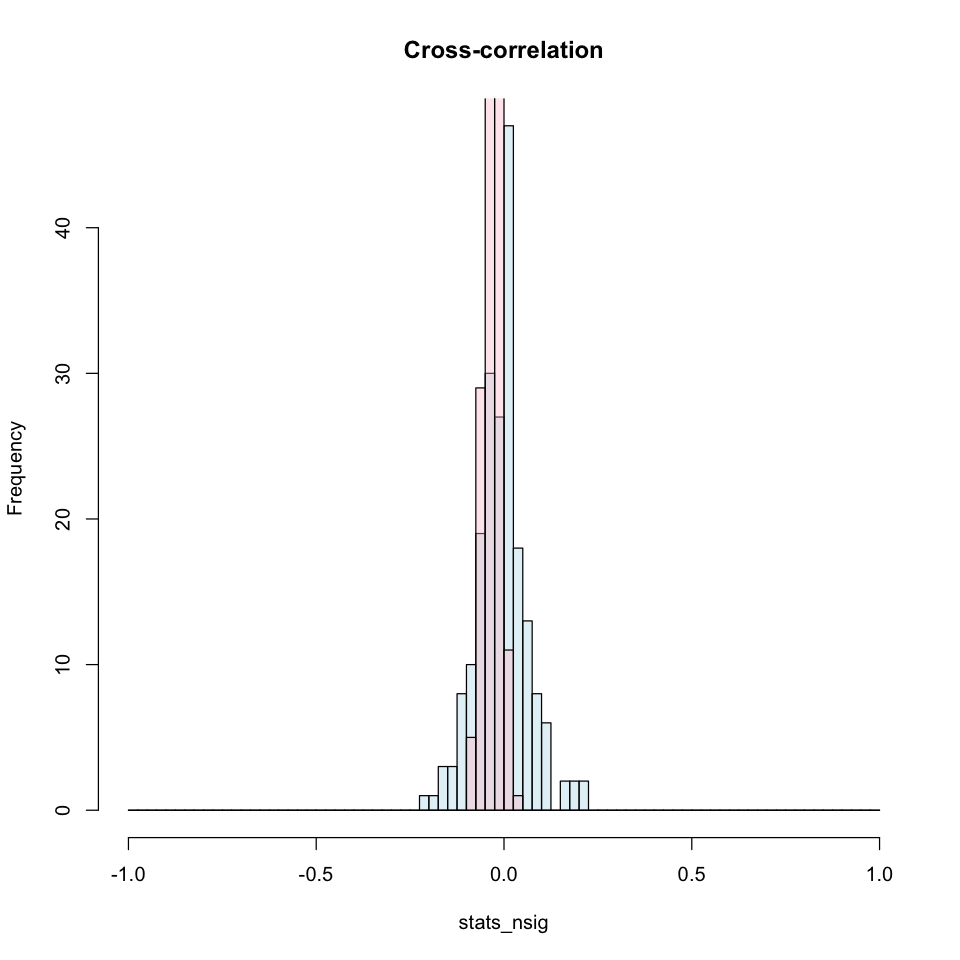

In [83]:
stats_nsig = c()
stats_sig = c()

for (r in rownames(results_tables[['real']])){
    sig.example = which(as.logical(response_setx[, r]))
    if ((r %in% names(sig.diffs)) & (length(stats_sig) < 200) ){
        mtest = mantel(dist(predictor_sets[['real']][sig.example,]), dist(predictor_sets[['permat']][sig.example,]))
        stats_sig = c(stats_sig, mtest$statistic)
    }
    if ((!(r %in% names(sig.diffs))) & (length(stats_nsig) < 200) ){
        mtest = mantel(dist(predictor_sets[['real']][sig.example,]), dist(predictor_sets[['permat']][sig.example,]))
        stats_nsig = c(stats_nsig, mtest$statistic)
    }
}

ax = seq(from=-1, to=1, by=0.025)
hgA_insig <- hist(stats_nsig, breaks = ax, plot = FALSE) # Save first histogram data
hgB_insig <- hist(stats_sig, breaks = ax, plot = FALSE) # Save 2nd histogram data
plot(hgA_insig, col = c1, main='Cross-correlation') # Plot 1st histogram using a transparent color
plot(hgB_insig, col = c2, add = TRUE)    


Combine predictor sets and load all the alternative predictive groups

In [132]:
# Load data and fix OEUs
oeu_file = '../data/oeu_clusters/oeu_abundances.txt'
fxn_file = "../data/faprotax_data/function_abundances.txt"
taxa_file = '../data/otu_tables/taxa_family_abundances.txt'

data_files = list('Taxa.Family'=taxa_file, 'Fxn.SILVA'=fxn_file, 'ASV.OEU'=oeu_file)
for (i in names(data_files)){
    temp_frame = read.delim(data_files[[i]], row.names=1)[rownames(env_responses),]
    data_objects[[i]] = temp_frame[which(rowSums(temp_frame) > 0), which(colSums(temp_frame) > 0)]
    print(colnames(data_objects[[i]])[1:3])
    print(c(dim(data_objects[[i]]), dim(temp_frame)))
}

# remove functions w/ >.95 correlation to other similarly named functions)
to_drop = c('methylotrophy', 'aerobic_ammonia_oxidation', 'sulfate_respiration',
            'dark_sulfite_oxidation', 'arsenate_respiration', 'nitrite_ammonification',
            'dissimilatory_arsenate_reduction', 'nitrite_denitrification', 
            'nitrous_oxide_denitrification', 'nitrate_denitrification', 'fumarate_respiration',
            'mammal_gut', 'plant_pathogen',  'cyanobacteria', 'phototrophy', 
            'anoxygenic_photoautotrophy_S_oxidizing', 'anoxygenic_photoautotrophy_Fe_oxidizing',
            'nitrate_respiration', 'aliphatic_non_methane_hydrocarbon_degradation', 
            'aerobic_chemoheterotrophy', 'nitrite_respiration', 'dark_sulfide_oxidation')

data_objects[['Fxn.SILVA']] = data_objects[['Fxn.SILVA']][,which(!(colnames(data_objects$Fxn.SILVA) %in% to_drop))]
dim(data_objects[['Raw.ASVs']])

numCores <- 3
counter = 0
folds = 10

score_summaries = paste(names(data_objects), 'Rsq', sep=".")
intercepts = paste(names(data_objects), '(Intercept)', sep=".")
predictor_list = unlist(lapply(data_objects, colnames))
names(predictor_list) <-NULL
all_summaries = c(score_summaries, intercepts, predictor_list)
vs_trial_df = data.frame(matrix(nrow=ncol(env_responses), ncol=length(all_summaries)))
rownames(vs_trial_df) = colnames(env_responses)
colnames(vs_trial_df) = all_summaries
dim(vs_trial_df)

resid_res_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/residual_analysis/responsive_populations.RData'

if (file.exists(resid_res_file)) {
    load(resid_res_file)
    print('Loaded residual results')
} else {
    library(glmnet)
    library(doParallel)
    registerDoParallel(3)
    start_time = Sys.time()
    
    for (trial in names(data_objects)){
        # extract predictor matrix
        predictors.t = as.matrix(data_objects[[trial]])
        pred_cols = colnames(predictors.t)
        print(c("Trial", trial))
    
        for (resp in colnames(env_responses)){
            # set seed by counter
            counter = counter + 1
            response.t = env_responses[,resp]
            names(response.t) <- rownames(env_responses)
            for (split.i in 1:folds) {
                this_counter = counter + split.i
                set.seed(this_counter)
                train_idx = createDataPartition(response.t, p=.75)[['Resample1']]
                test_idx = setdiff(1:nrow(predictors.t), train_idx)
                predictors.t.tr <- predictors.t[train_idx, ]; 
                predictors.t.tst <- predictors.t[test_idx, ]; 
                response.t.tr <- response.t[train_idx]
                response.t.tst <- response.t[test_idx]
                
                cvfit.tr <- cv.glmnet(x=predictors.t.tr, y=response.t.tr, family = "gaussian", 
                                      nfolds = 5, parallel = T)
                
                # predict on held out data
                fitted_values.tst = predict(cvfit.tr, newx=predictors.t.tst, s = 'lambda.min')
                rsq.tst = postResample(fitted_values.tst, response.t.tst)['Rsquared']
                rsq.tst = matrix(rsq.tst, nrow=1,ncol=1, 
                                 dimnames=list(c(paste(trial,'Rsq',sep=".")), c(split.i)))
                coef.tr = as.matrix(coef(cvfit.tr, s = "lambda.min"))
                colnames(coef.tr) <- c(split.i)
                if (split.i == 1) {
                    fold.scores = rbind(coef.tr, rsq.tst)
                } else {
                    fold.scores = cbind(fold.scores, rbind(coef.tr, rsq.tst))
                }
            }
            # move counter forward to initiate new seeds 
            counter = counter + folds
            folded.scores = apply(fold.scores, 1, function(x) {mean(x, na.rm=T)})
            # give the intercept a model specific name 
            names(folded.scores)[names(folded.scores) == '(Intercept)'] = paste(trial, '(Intercept)', sep=".")
            vs_trial_df[resp, names(folded.scores)] = folded.scores            
            progress_meter = counter/(nrow(vs_trial_df)*(folds+1)*length(data_objects))
            end_time = Sys.time();
            print(paste('Complete: ', round(progress_meter*100, 1), "%", sep="" ))
            print(end_time - start_time);
            flush.console()
        }
    }
    stopImplicitCluster()
    save(vs_trial_df, file=resid_res_file)
    print('Saved residual results')
}


[1] "Trial"       "Taxa.Family"
[1] "Complete: 4.2%"
Time difference of 2.672239 secs
[1] "Complete: 8.3%"
Time difference of 4.962299 secs
[1] "Complete: 12.5%"
Time difference of 7.457955 secs
[1] "Complete: 16.7%"
Time difference of 9.929469 secs
[1] "Complete: 20.8%"
Time difference of 12.52985 secs
[1] "Complete: 25%"
Time difference of 15.24963 secs
[1] "Trial"     "Fxn.SILVA"
[1] "Complete: 29.2%"
Time difference of 17.29419 secs
[1] "Complete: 33.3%"
Time difference of 19.07267 secs
[1] "Complete: 37.5%"
Time difference of 21.2755 secs
[1] "Complete: 41.7%"
Time difference of 22.75519 secs
[1] "Complete: 45.8%"
Time difference of 25.15384 secs
[1] "Complete: 50%"
Time difference of 27.00026 secs
[1] "Trial"   "ASV.OEU"
[1] "Complete: 54.2%"
Time difference of 28.78924 secs
[1] "Complete: 58.3%"
Time difference of 30.53403 secs
[1] "Complete: 62.5%"
Time difference of 32.56773 secs
[1] "Complete: 66.7%"
Time difference of 34.35439 secs
[1] "Complete: 70.8%"
Time difference of 35

In [133]:
vs_trial_df[,1:5]

,Taxa.Family.Rsq,Fxn.SILVA.Rsq,ASV.OEU.Rsq,Raw.ASVs.Rsq,Taxa.Family.(Intercept)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NO2F_residuals,0.2240095,0.2562233,0.2282639,0.2239546,-0.22118634
PO4F_residuals,0.5618631,0.4934926,0.4624343,0.7541132,-0.04945174
DO_residuals,0.4209347,0.3662587,0.3921867,0.5821064,0.19339449
DO,0.7549235,0.6618630,0.6604019,0.7425278,0.17832733
PO4F,0.7338445,0.7089417,0.7016785,0.8109938,-0.20498113
NO2F,0.6294084,0.4780381,0.5842950,0.5935658,0.21093735


In [129]:
vs_trial_df[,1:5]

,Taxa.Family.Rsq,Fxn.SILVA.Rsq,ASV.OEU.Rsq,Raw.ASVs.Rsq,Taxa.Family.(Intercept)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NO2F_residuals,0.1166157,0.1804318,0.2376700,0.2239546,-0.2618201
PO4F_residuals,0.5321472,0.4290697,0.6462519,0.7541132,1.0068240
DO_residuals,0.4670383,0.3762744,0.6052352,0.5821064,-0.1783202
DO,0.7630733,0.6321803,0.7251997,0.7425278,0.4391249
PO4F,0.7902530,0.7070802,0.7857875,0.8109938,0.1498954
NO2F,0.5971486,0.5203363,0.5717783,0.5935658,0.5576737


In [ ]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(foreach))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(grid))

In [ ]:
# start the timer
start_time = Sys.time()
# iterate over predictor sets
for (trial in names(data_objects)){
    # extract predictor matrix
    raw_pred_df = data_objects[[trial]]
    pred_cols = colnames(raw_pred_df)
    print(c("Trial", trial))
    
    for (resp in names(response_set)){
        # set seed 
        counter = counter + 1
        set.seed(123*counter)
        # combine into 1 object

        pred_resp = cbind.data.frame(raw_pred_df, response_set[,resp])
        colnames(pred_resp) <- c(colnames(raw_pred_df), resp)
        
        # make a tune grid
        if (class(response_set[,resp]) == 'factor'){
            default.var = floor(sqrt(ncol(raw_pred_df)))
        } else {
            default.var = max(floor(ncol(raw_pred_df)/3), 1)
        }
        
        # tune the RF model (1)
        control <- trainControl(method="cv", number=5)
        tune.grid.full <- expand.grid(mtry=unique(round(default.var*(seq(0.5, 1.5, 0.1)))))
        rf_default <- train(x=pred_resp[,pred_cols], y=pred_resp[,resp], 
                            method="rf", tuneGrid=tune.grid.full, trControl=control)
        opt_mtry_full = rf_default$bestTune[['mtry']]

        # prefilter
        prf_model = randomForest(x=pred_resp[,pred_cols], y=pred_resp[,resp], 
                                 ntree = 250, random_state=counter, mtry=opt_mtry_full,
                                 importance=T)

        # get full importances and prefilter
        pvar_import = importance(prf_model, type=1, scale=F)
        sorted_VIs = base::sort(pvar_import, index.return=T)
        sel_vars = rownames(pvar_import)[sorted_VIs$ix[1:40]]

        # retune 3
        if (class(response_set[,resp]) == 'factor'){
            default.var.slim = floor(sqrt(length(sel_vars)))
        } else {
            default.var.slim = max(floor(length(sel_vars)/3), 1)
        }
        
        tune.grid.slim <- expand.grid(mtry=unique(round(default.var.slim*(seq(0.5, 1.5, 0.1)))))
        rf_slim <- train(x=pred_resp[,sel_vars], y=pred_resp[,resp], 
                         method="rf", tuneGrid=tune.grid.slim, trControl=control)
        opt_mtry_slim = rf_slim$bestTune[['mtry']]

        cat(trial, "--", resp, "\n")
        end_time = Sys.time(); print(end_time - start_time);
        
        # fit full and slim models 10fold
        registerDoParallel(numCores)
        results = foreach(i=1:folds, .combine=data.frame) %dopar% {

            # split into test/train
            this_counter = counter + i
            set.seed(123*this_counter)
            train_ind = createDataPartition(response_set[,resp], p=.75, list = FALSE)
            train_df <- pred_resp[train_ind, ]
            test_df <- pred_resp[-train_ind, ]
            
            # if factors were dropped from training or test df, drop from both 
            if (class(response_set[,resp]) == 'factor') {
                avail_levels = intersect(unique(test_df[,resp]), unique(test_df[,resp]))
                missing_levels = setdiff(unique(pred_resp[,resp]), avail_levels)
                if (length(missing_levels) > 0){
                    train_df = train_df[!(train_df[,resp] %in% missing_levels),]
                    test_df = test_df[!(test_df[,resp] %in% missing_levels),]
                    test_df[,resp] <- droplevels(test_df[,resp])
                    train_df[,resp] <- droplevels(train_df[,resp])
                }
            }

            rf_model = randomForest(x = train_df[,sel_vars], y = train_df[,resp], 
                                    ntree = 250, random_state=this_counter, mtry=opt_mtry_slim)
            
            rf_model2 = randomForest(x = train_df[,pred_cols], y = train_df[,resp], 
                                     ntree = 250, random_state=this_counter, mtry=opt_mtry_full,
                                    importance=T)

            # preditct for both
            rf_pred_test = predict(rf_model, newdata = test_df[,sel_vars])
            rf_pred_test2 = predict(rf_model2, newdata = test_df[,pred_cols])

            # score 
            if (class(response_set[,resp]) == 'factor') {
                rf_cm = confusionMatrix(rf_pred_test, test_df[,resp])
                rf_score = 1 - rf_cm$overall['Accuracy']

                rf_cm2 = confusionMatrix(rf_pred_test2, test_df[,resp])
                rf_score2 = 1 - rf_cm2$overall['Accuracy']
            } else {
                rf_score = postResample(pred = rf_pred_test, obs = test_df[,resp])[['MAE']]
                rf_score2 = postResample(pred = rf_pred_test2, obs = test_df[,resp])[['MAE']]
            }    

            # report
            var_import = as.data.frame(importance(rf_model2, type=1, scale=T))
            colnames(var_import) <- paste('MetricOrDeltaMetric', i, sep=".")
            var_import[paste(trial, 'Full', sep="."), c(1)] = rf_score2
            var_import[paste(trial, 'Slim', sep="."), c(1)] = rf_score
            var_import
        }
        
        stopImplicitCluster()
        flush.console()

        # move counter forward to initiate new seeds 
        counter = counter + folds

        # take the mean of each fold 
        scores = apply(results, MARGIN=1, FUN=mean)
        for (score_col in names(scores))
            vs_trial_df[resp, score_col] = scores[[score_col]]

        print(paste('Complete: ', round((counter/(dim(response_set)[2]*3*11))*100, 1), "%", sep="" ))
        end_time = Sys.time(); print(end_time - start_time);

    }
}

write.table(x = vs_trial_df,
            file = "/Volumes/KeithSSD/CB_V4/otu_data/beta_diversity_analysis/beta_diversity_varsel_final3.txt", 
            row.names = T, 
            col.names = T, 
            sep = '\t')


In [ ]:
options(repr.plot.width=7.5, repr.plot.height=5)
to_plot1 = t(vs_trial_df[,1:6])
to_plot2 = apply(as.data.frame(to_plot1), 2, as.numeric)
to_plot2 = cbind.data.frame(to_plot2, factor(c(rep('Full', 3), rep('Reduced', 3))), 
                 factor(rep(names(data_objects), 2)))
colnames(to_plot2) <- c(colnames(to_plot1), 'Model.Size', 'Data.Type')
to_plot3 = melt(to_plot2, id.vars=c("Data.Type", 'Model.Size'), 
                measure.vars=colnames(to_plot1), variable.name='Variable',
                value.name='Error')
to_plot4 = to_plot3[which(to_plot3$Model.Size != 'Reduced'),]
#to_plot4 = to_plot4[which(to_plot4$Variable != 'Pct.Tot.Depth'),]
#to_plot4$Variable <- droplevels(to_plot4$Variable)
#levels(to_plot4$Variable)
to_plot4$Data.Type <- factor(to_plot4$Data.Type, levels=c('ASV.OEU', 'Taxa.Family', 'Fxn.SILVA'))
levels(to_plot4$Data.Type) <- c('OEU', 'Fxn', 'Taxa')

to_plot4$Variable <-  factor(to_plot4$Variable, levels=c('Years', 'Season', 'Discharge', 'WTEMP', 
                                                         'Salinity', 'Station.Group', 'Density', 
                                                         'Habitat', 'NO3', 'NO2', 'NH4', 'CHLA', 
                                                         'PHEO', 'TP'))

bp <- ggplot(to_plot4, aes(x=Data.Type, y=Error, fill=Data.Type)) + 
      geom_bar(stat="identity", position=position_dodge()) + 
      facet_wrap(~ Variable, ncol=5) + scale_fill_grey() + 
      theme_minimal() + theme(text = element_text(size=12), axis.text.x=element_blank())
bp


In [ ]:
res.aov <- aov(Error ~ Data.Type, data = to_plot4)
summary(res.aov)
TukeyHSD(res.aov)
aggregate(to_plot4[,'Error'], by=list(to_plot4[,'Data.Type']), mean)
var_perf = aggregate(to_plot4[,'Error'], by=list(to_plot4[,'Variable']), min)
var_perf[,'best'] <- NA
for (v in 1:nrow(var_perf)){
    vsub = to_plot4[which(to_plot4$Variable == var_perf[v, 'Group.1']),]
    vstr = paste(vsub[(which(vsub$Error == min(vsub$Error))), 'Data.Type'], collapse=", ")
    var_perf[v ,'best'] <- vstr
}
var_perf

In [ ]:
options(repr.plot.width=7.5, repr.plot.height=5)
trial_df = vs_trial_df
fxnNames = colnames(data_objects[['Fxn.SILVA']])
familyNames = colnames(data_objects[['Taxa.Family']])
oeuNames = colnames(data_objects[['ASV.OEU']])
Max.VI.Taxa = apply(trial_df[,familyNames], MARGIN=1, FUN=function(x) {max(x, na.rm=T)})
Max.VI.Fxns = apply(trial_df[,fxnNames], MARGIN=1, FUN=function(x) {max(x, na.rm=T)})
Max.VI.OEU = apply(trial_df[,oeuNames], MARGIN=1, FUN=function(x) {max(x, na.rm=T)})
Mean.VI.Taxa = apply(trial_df[,familyNames], MARGIN=1, FUN=function(x) {mean(x, na.rm=T)})
Mean.VI.Fxns = apply(trial_df[,fxnNames], MARGIN=1, FUN=function(x) {mean(x, na.rm=T)})
Mean.VI.OEU = apply(trial_df[,oeuNames], MARGIN=1, FUN=function(x) {mean(x, na.rm=T)})

dropped_df = cbind.data.frame(Max.VI.Taxa, Max.VI.Fxns, Max.VI.OEU,
                              Mean.VI.Taxa, Mean.VI.Fxns, Mean.VI.OEU)
dropped_df$Variables <- rownames(dropped_df)
to_plot5 = to_plot4
colnames(to_plot5) <- c('Data.Type', 'Stat', 'Variable', 'Var.Importance')
data.types_ = c('Taxa', 'Fxn', 'OEU')
to_plot6 = to_plot5
to_plot5[,'Stat'] = 'Max'
to_plot6[,'Stat'] = 'Mean'
for (r in rownames(dropped_df)){
    for (c in 1:3){
        b1 = to_plot5$Data.Type == data.types_[c]
        b2 = to_plot5$Variable == r
        to_plot5[which(b1 & b2), 'Var.Importance'] = dropped_df[r, c]
        to_plot5[which(b1 & b2), 'Stat'] = 'Max'
        to_plot6[which(b1 & b2), 'Var.Importance'] = dropped_df[r, c+3]
        to_plot6[which(b1 & b2), 'Stat'] = 'Mean'
    }
}
to_plot7 = rbind.data.frame(to_plot5, to_plot6)

bp <- ggplot(to_plot5, aes(x=Data.Type, y=Var.Importance, fill=Data.Type)) + 
      geom_bar(stat="identity", position=position_dodge()) + 
      facet_wrap(~ Variable, ncol=5) + scale_fill_grey() + 
      theme_minimal() + theme(text = element_text(size=12), axis.text.x=element_blank())
bp



In [ ]:
# CHLA NO2, WTEMP, Fxn fxnNames
# Discharge Taxa familyNames
# PHEO and NO3 OEU oeuNames
response_set2 = response_set

varimport_df = trial_df[,c(familyNames, fxnNames, oeuNames)]
good_wc_columns = c('CHLA', 'PHEO', 'NO3', 'NO2', "Discharge", "WTEMP", 'NH4', 'Season')

# extract correlations between environmental data and 16S-based predictors
feat_corrs = data.frame(matrix(nrow=ncol(varimport_df), ncol=length(good_wc_columns)))
colnames(feat_corrs) <- good_wc_columns
rownames(feat_corrs) <- colnames(varimport_df)

all_features = cbind.data.frame(data_objects[['Taxa.Family']], 
                                data_objects[['Fxn.SILVA']], 
                                data_objects[['ASV.OEU']])
for (feat in rownames(feat_corrs)){
    for (a_var in colnames(feat_corrs)){
        env_pred = cbind.data.frame(response_set2[,a_var], all_features[,feat])
        feat_corrs[feat, a_var] = cor(env_pred)[1,2]
    }
}

corr_signs = feat_corrs
corr_signs = ifelse(corr_signs < 0, -1, 1)
sum(colSums(feat_corrs == 0))



In [ ]:
vidf_num_rows=length(data_objects)*length(good_wc_columns)*3

var.import.df = data.frame(matrix(nrow=vidf_num_rows, ncol=5))
counter = 0
colnames(var.import.df) <- c('Data.Type', 'Variable', 'Name', 'Importance', 'Correlation')
colsets = list('Taxa'=familyNames, 'Fxn'=fxnNames, 'OEU'=oeuNames)
for (a_var in good_wc_columns){
    for (data.tipo in names(colsets)){
        all_feats = trial_df[a_var, colsets[[data.tipo]]]
        all_feats = all_feats[,which(!is.na(all_feats[a_var,]))]
        srt_feats = base::sort(all_feats, decreasing = T)[,1:3]
        for (rank in 1:3){
            counter = counter + 1
            var.import.df[counter, 'Data.Type'] = data.tipo
            var.import.df[counter, 'Variable'] = a_var
            var.import.df[counter, 'Name'] = names(srt_feats)[rank]
            var.import.df[counter, 'Importance'] = srt_feats[rank]
            var.import.df[counter, 'Correlation'] = feat_corrs[names(srt_feats)[rank], a_var]
        }
    }
}

var.import.df[1:25, ]
var.import.df[25:50, ]
var.import.df[50:72, ]
table(var.import.df$Name)

In [ ]:

tenv_data$Cruise.Num <- NA
varJD = tenv_data$julian_day
tenv_data[ (varJD < 572), 'Cruise.Num'] <- '1'
tenv_data[ (varJD > 571) & (varJD < 601), 'Cruise.Num'] <- '2'
tenv_data[ (varJD > 600) & (varJD < 621), 'Cruise.Num'] <- '3'
tenv_data[ (varJD > 841) & (varJD < 870), 'Cruise.Num'] <- '4'
tenv_data[ (varJD > 869) & (varJD < 899), 'Cruise.Num'] <- '5'
tenv_data[ (varJD > 898) & (varJD < 919), 'Cruise.Num'] <- '6'
tenv_data[ (varJD > 918) & (varJD < 962), 'Cruise.Num'] <- '6'
tenv_data[ (varJD > 961) & (varJD < 984), 'Cruise.Num'] <- '7'
tenv_data[ (varJD > 983) & (varJD < 1006), 'Cruise.Num'] <- '8'
tenv_data[ (varJD > 1005), 'Cruise.Num'] <- '9'
table(tenv_data$Cruise.Num)

resp_set2 = response_set
resp_set2$Cruise.Num = factor(tenv_data$Cruise.Num)



In [ ]:
options(repr.plot.width=7, repr.plot.height=5)

cruise.stat = paste("C", resp_set2$Cruise.Num, 
                    "S", as.character(resp_set2$Station.Group), sep=".")
length(unique(cruise.stat))
cruise.stat.levels = expand.grid(paste("S", 1:6, sep="."), paste("C",1:9, sep="."))
cruise.stat.levels = paste(cruise.stat.levels$Var2, cruise.stat.levels$Var1, sep=".")

resp_set2[,'Cruise.Station'] <- droplevels(factor(cruise.stat, levels=cruise.stat.levels))
srt_response = resp_set2[with(resp_set2, order(Cruise.Station)),]
colorder = rownames(srt_response)
oeu_df2 = data_objects[['ASV.OEU']]

oeu_df3 = cbind.data.frame(oeu_df2[colorder,], resp_set2[,'Cruise.Station'])
colnames(oeu_df3) <- c(colnames(oeu_df2), 'Cruise.Station')
oeu_df3[,'id'] <- rownames(oeu_df3)
oeu_melt = melt(oeu_df3, id.vars=c("id", 'Cruise.Station'), 
                measure.vars=colnames(oeu_df2), variable.name='OEU',
                value.name='Abund')

oeu_melt_agg = aggregate(Abund~Cruise.Station+OEU, oeu_melt, FUN=mean)
oeu_df4 = dcast(oeu_melt_agg, Cruise.Station ~ OEU, value.var='Abund')


rownames(oeu_df4) <- oeu_df4$Cruise.Station
oeu_df4$Cruise.Station <- NULL
oeu_vars = apply(oeu_df4, 2, var)
sorted_oeu_vars = base::sort(oeu_vars, index.return=T, decreasing=T)
hi_var_oeus = names(oeu_vars)[sorted_oeu_vars$ix[1:100]]
oeu_df5 = oeu_df4[,hi_var_oeus]
srt_oeu = as.matrix(t(oeu_df5))

hmanno = data.frame('Season'=c(), 'Latitude'=c())

for (n in colnames(srt_oeu)){
    samps.lats = tenv_data[which(resp_set2$Cruise.Station == n), 'Latitude']
    hmanno[n, 'Latitude'] = mean(samps.lats)
    stat.seasonx = tenv_data[which(resp_set2$Cruise.Station == n), 'anti_day_length']
    hmanno[n, 'Season'] = mean(stat.seasonx)
    stat.month = (as.numeric(tenv_data[which(resp_set2$Cruise.Station == n), 'julian_day'])-365)/365
    hmanno[n, 'Years'] = mean(stat.month)
}

row_ha = HeatmapAnnotation(
    'Years' = hmanno$Years,
    'Season' = hmanno$Season, 
    'Latitude' = hmanno$Latitude, 
    col = list('Years' = colorRamp2(c(min(hmanno$Years),max(hmanno$Years)), c("#FEBAB9", "#A90301")),
               'Season' = colorRamp2(c(-.93,0.99), c('#F4D6FC', '#780197')),
               'Latitude' = colorRamp2(as.vector(quantile(hmanno$Latitude, c(0.05, 0.95))),
                                       c("#A7FDA7", "#018501")))
)


col_fun = colorRamp2(as.vector(quantile(srt_oeu, c(0.1, 0.5, 0.9))), c("#FFFFFF", '#888888', "#000000"))

Heatmap(srt_oeu, col = col_fun, name='LogRPM', top_annotation = row_ha, 
        cluster_columns=F,  show_row_names = F, show_column_names=F,
        column_title_side='bottom', column_title='Samples', row_title='OEUs',
        row_title_side='left', gap = unit(1, "mm"))
?Heatmap
#colSide <- brewer.pal(9, "Set1")[my_group]
#colMain <- colorRampPalette(brewer.pal(8, "Blues"))(25)
#heatmap(data, Colv = NA, Rowv = NA, scale="column" , RowSideColors=colSide, col=colMain   )

In [ ]:
options(repr.plot.width=7, repr.plot.height=8)
Heatmap(srt_oeu, col = col_fun, name='LogAbund', top_annotation = row_ha, 
        cluster_columns=F,  show_row_names = T, show_column_names=F, row_names_gp = gpar(fontsize = 7))

In [ ]:
taxa_file2 = "/Volumes/KeithSSD/CB_V4/otu_data/dada2_outputs/taxa_table_with_OTUs.txt"
pre_taxa_df = read.delim(taxa_file2, row.names=1)
pre_taxa_df[pre_taxa_df==""] <- NA

otu_table_file2 = '/Volumes/KeithSSD/CB_V4/otu_data/final_unrarefied_table.txt'
otu_table2 = read.delim(otu_table_file2, row.names=1)[rownames(response_set),]
otu_table2 = otu_table2[,which(colSums(otu_table2) > 0)]

dim(otu_table2)
all_unrare_asvs = colnames(otu_table2)
all_unrare_asvs[1:5]
taxa_present = pre_taxa_df[all_unrare_asvs,]

all_taxa_levels_present = c(as.character(taxa_present$Phylum), 
                            as.character(taxa_present$Class), 
                            as.character(taxa_present$Order), 
                            as.character(taxa_present$Family), 
                            as.character(taxa_present$Genus))
all_taxa_levels_present = all_taxa_levels_present[!is.na(all_taxa_levels_present)]
all_taxa_levels_present[1:5]
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrospiraceae'))
length(nitro_asvs)
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrosococcus'))
length(nitro_asvs)
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrosomonas'))
length(nitro_asvs)
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrosopumilaceae'))
length(nitro_asvs)


In [ ]:
# print out the number of functions and taxa with z-val > 1 
num_sig_feats = data.frame()
sig_tax = list(); sig_fxn = list();
sig_func_set = c(); sig_tax_set = c();

In [ ]:
fxn_by_taxa_df = read.delim("/Users/login/Google Drive/SiYi_Xiaotong_Materials/FAPROTAX_Functions_by_family.txt", 
                            row.names=1)

In [ ]:
sig_func_tally = c(); sig_taxa_tally = c();

for (gcww in good_wc_columns){
    for (gcww_i in gcww){
        all_fxns = varimport_df[gcww_i, fxn_cols] #
        all_tax = varimport_df[gcww_i, taxa_cols] #
        srt_fxn = base::sort(all_fxns, decreasing = T) #
        srt_tax = base::sort(all_tax, decreasing = T) #
        srt_fxn_sign = srt_fxn; srt_tax_sign = srt_tax; #
        for (n in names(srt_fxn_sign)){ srt_fxn_sign[n] = srt_fxn[n]* corr_signs[n, gcww_i] }#
        for (n in names(srt_tax_sign)){ srt_tax_sign[n] = srt_tax[n]* corr_signs[n, gcww_i] }#
        
        # carryout list 
        sig_fxn[[gcww_i]] = as.vector(names(srt_fxn_sign))
        sig_tax[[gcww_i]] = as.vector(names(srt_tax_sign))
        # update dataframe
        num_sig_feats[gcww_i, 'nfxn'] = length(sig_fxn[[gcww_i]])
        num_sig_feats[gcww_i, 'ntax'] = length(sig_tax[[gcww_i]])
        # update set
        sig_func_set = union(sig_func_set, sig_fxn[[gcww_i]])
        sig_tax_set = union(sig_tax_set, sig_tax[[gcww_i]])
        
        sig_func_tally = c(sig_func_tally, sig_fxn[[gcww_i]])
        sig_taxa_tally = c(sig_taxa_tally, sig_tax[[gcww_i]])
        
        # add annotation data
        annotated_taxa = sig_tax[[gcww_i]][sig_tax[[gcww_i]] %in% colnames(fxn_by_taxa_df)]
        missing_taxa = sig_tax[[gcww_i]][(sig_tax[[gcww_i]] %in% colnames(fxn_by_taxa_df)) == FALSE]
        annotation_submat = fxn_by_taxa_df[sig_fxn[[gcww_i]], annotated_taxa]
        if (is.null(dim(annotation_submat))){
            annotation_bool = sapply(annotation_submat, sum) > 0
        } else{
            annotation_bool = apply(annotation_submat, MARGIN=2, sum) > 0
        }
        
        annotation_hits = annotated_taxa[annotation_bool]
        annotaion_misses = c(missing_taxa, annotated_taxa[!(annotation_bool)])

        num_sig_feats[gcww_i, 'n_tax_classif'] = length(annotation_hits)
        num_sig_feats[gcww_i, 'n_tax_not_classif'] = length(annotaion_misses)
        
        
        # pull out some names and numbers 
        cols_remaining = c('sig_fxns', 'sig_taxa_grps')
        
        func_corrs = srt_fxn; tax_corrs = srt_tax;
        for (n in names(srt_fxn_sign)){ func_corrs[n] = corr_scores[n, gcww_i] }#
        for (n in names(srt_tax_sign)){ tax_corrs[n] = corr_scores[n, gcww_i] }#
        
        sig_fxn_list = paste(sig_fxn[[gcww_i]], round(srt_fxn_sign[sig_fxn[[gcww_i]]],  2), sep=":")
        cor_fxn_list = paste(sig_fxn[[gcww_i]], round(func_corrs[sig_fxn[[gcww_i]]],  2), sep=":")
        
        sig_taxa_names = sapply(sig_tax[[gcww_i]], FUN=function(y) {strsplit(y, '.', fixed=T)[[1]][2]})
        sig_taxa_list = paste(sig_taxa_names, round(srt_tax_sign[sig_tax[[gcww_i]]],  2), sep=":")
        cor_taxa_list = paste(sig_taxa_names, round(tax_corrs[sig_tax[[gcww_i]]],  2), sep=":")
        
        num_sig_feats[gcww_i, 'sig_fxns'] = paste(sig_fxn_list, collapse=", ")
        num_sig_feats[gcww_i, 'corr_fxns'] = paste(cor_fxn_list, collapse=", ")
        num_sig_feats[gcww_i, 'sig_tax_grps'] = paste(sig_taxa_list, collapse=", ")
        num_sig_feats[gcww_i, 'cor_tax_grps'] = paste(cor_taxa_list, collapse=", ")
        
        num_sig_feats[gcww_i, 'classif_tax'] = paste(annotation_hits, collapse=", ")
        num_sig_feats[gcww_i, 'unclassif_tax'] = paste(annotaion_misses, collapse=", ")
        
    }
    
    # see how many overlap between multifunctions
    if (length(gcww) > 1) {
        fxn_ol = sig_fxn[[gcww[1]]]; tax_ol = sig_tax[[gcww[1]]];
        for (i in 2:length(gcww)){
            fxn_ol = intersect(sig_fxn[[gcww[i]]], fxn_ol) 
            tax_ol = intersect(sig_tax[[gcww[i]]], tax_ol)
        }
        num_sig_feats[gcww, 'ntax_overlap'] <- length(fxn_ol)
        num_sig_feats[gcww, 'nfxn_overlap'] <- length(tax_ol)
    }
}

head(base::sort(table(sig_func_tally), decreasing=T))
head(base::sort(table(sig_taxa_tally), decreasing=T))

print(length(sig_func_set))
print(length(sig_tax_set))



In [ ]:
num_sig_feats

In [ ]:
write.table(num_sig_feats, sep="\t", row.names=T, 
            file="../otu_data/beta_diversity_analysis/variable_importances.txt")

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
library(corrplot)
library(RColorBrewer)

subset_bool = complete.cases(env_data)
sig_fxn_abunds = fxn_abund_df[subset_bool,sig_func_set]
dist_fxn <- dist(t(sig_fxn_abunds), method = 'euclidean')
hclust_fxn <- hclust(dist_fxn, method = 'ward.D2')
fxns_ordered = colnames(sig_fxn_abunds)[hclust_fxn$order]

sig_taxa_abunds = taxa_abund_df[subset_bool,sig_tax_set]
dist_tax <- dist(t(sig_taxa_abunds), method = 'euclidean')
hclust_tax <- hclust(dist_tax, method = 'ward.D2')
tax_ordered = colnames(sig_taxa_abunds)[hclust_tax$order]

good_wc_columns2 = c('CHLA', 'PHEO', 'DO', 'NO3F', 'NO2F', "PC", 'SALINITY', 'Latitude',
                    'faith_pd', 'Year', "NH4F", 'Discharge_Susquehanna_14', 'anti_day_length',
                    'Month', 'WTEMP', 'StatName', 'DOP', 'habitat')

env_numeric = apply(env_data[subset_bool,good_wc_columns2], 2, as.numeric)
dist_env <- dist(t(env_numeric), method = 'euclidean')
hclust_env <- hclust(dist_env, method = 'ward.D2')
env_ordered = colnames(env_numeric)[hclust_env$order]



cor.mtest <- function(mat1, mat2) {
    mat1 <- as.matrix(mat1)
    mat2 <- as.matrix(mat2)
    p.mat <- matrix(NA, ncol(mat1), ncol(mat2))
    for (i in 1:ncol(mat1)) {
        for (j in 1:ncol(mat2)) {
            tmp <- cor.test(mat1[, i], mat2[, j])
            p.mat[i, j] <- tmp$p.value
        }
    }
    colnames(p.mat) <- colnames(mat2)
    rownames(p.mat) <- colnames(mat1)
    return(p.mat)
}

M <- cor(sig_taxa_abunds[,tax_ordered], env_numeric[,env_ordered])
M.p <- cor.mtest(sig_taxa_abunds[,tax_ordered], env_numeric[,env_ordered])
rownames(M)[rownames(M) == 'nan'] <- 'nan.Unknown'

orig_names = rownames(M)
clean_taxa_names = unlist(lapply(rownames(M), FUN=function(y) {regmatches(y, regexpr("\\.",y), invert = TRUE)[[1]][2]}))

rownames(M) <- clean_taxa_names
rownames(M.p) <- clean_taxa_names

M.2 = M[rowSums(M.p < 0.05) > (0.5)*length(env_ordered), ]
M.p.2 = M.p[rowSums(M.p < 0.05) > (0.5)*length(env_ordered), ]

orig_names = orig_names[rowSums(M.p < 0.05) > (0.5)*length(env_ordered)]

plotname = "../otu_data/beta_diversity_analysis/env_taxa_correlations2.png"
png(filename = plotname, width = 480*5.3, height = 5.3*620, units = "px", res = 300)

#tl.cex=2, 
corrplot(M.2, method='ellipse', order="original", tl.col = "black", 
         col=brewer.pal(n=8, name="PuOr"), p.mat = M.p.2, sig.level = 0.05, insig='blank', 
         addgrid.col=NA, cl.cex=1.8, tl.cex=0.8, cl.align.text='l')
dev.off()

In [ ]:
a_fxn = c("oxygenic_photoautotrophy", 'hydrocarbon_degradation')
a_taxa = c("Planctomycetales.Gimesiaceae")
env_vars = c("DO", 'NH4F', 'CHLA', 'PC')
pre_env = cbind.data.frame(env_data[,env_vars], taxa_abund_df[,a_taxa], fxn_abund_df[,a_fxn])
colnames(pre_env) <- c(env_vars, a_taxa, a_fxn)
pre_env2 = pre_env[rowSums(is.na(pre_env)) == 0,]
cor(pre_env2)

In [ ]:
clust1 = orig_names[69:76]
clust1.1 = orig_names[66:68]
clust2 = orig_names[60:65]
clust3 = orig_names[52:59]
clust4 = orig_names[41:51]
clust5 = orig_names[32:40]
clust6 = orig_names[18:31]
clust7 = orig_names[6:17]
clust8 = orig_names[1:5]

cluster_names = list(c(clust1, clust1.1), clust2, clust3, clust4, clust5, clust6, clust7, clust8)

indicator_fxn = c('SALINITY', 'WTEMP', 'DO', 'NH4F')

env_data$depth_segment <- as.character(env_data$depth_segment)
env_data[is.na(env_data$depth_segment), 'depth_segment'] = 'Mid'
env_data$depth_segment <- as.integer(factor(env_data$depth_segment, levels = c('Bottom', 'Mid', 'Top')))

indicator_numeric = apply(env_data[subset_bool, indicator_fxn], 2, as.numeric)
summary_df = data.frame(matrix(nrow=length(cluster_names), ncol=length(indicator_fxn)*2))
rownames(summary_df) <- paste('Cluster', 1:length(cluster_names), sep=".")
namestobe <- c(paste('Mean', indicator_fxn, sep="."), paste('SD', indicator_fxn, sep="."))
name_order = base::sort(namestobe, decreasing=T)
colnames(summary_df) <- name_order

for (i in 1:length(cluster_names)){
    this_clust = cluster_names[[i]]
    this_clust = this_clust[this_clust != 'nan.Unknown']
    clust_abunds = rowSums(sig_taxa_abunds[,this_clust])
    hotspots = clust_abunds > unlist(quantile(clust_abunds, c(.75)))[[1]]
    summary_data = c(apply(indicator_numeric[hotspots,], 2, mean), apply(indicator_numeric[hotspots,], 2, sd))  
    names(summary_data) <- c(paste('Mean', indicator_fxn, sep="."), paste('SD', indicator_fxn, sep="."))
    name_order = base::sort(names(summary_data), decreasing=T)
    summary_df[rownames(summary_df)[i], ] = summary_data[name_order]
    
}

summary_df_toprint = round(summary_df[order(summary_df$Mean.WTEMP),c(5, 1, 6, 2, 7, 3, 8, 4)], 2)
write.table(summary_df_toprint, file="../otu_data/beta_diversity_analysis/cluster_env_table.txt", sep="\t",
           row.names=T)

In [ ]:
fxn_by_taxa_df = read.delim("/Users/login/Google Drive/SiYi_Xiaotong_Materials/FAPROTAX_Functions_by_family.txt", row.names=1)
print(sum(fxns_ordered %in% rownames(fxn_by_taxa_df)))
print(sum(tax_ordered %in% colnames(fxn_by_taxa_df)))

missing_taxa = tax_ordered[(tax_ordered %in% colnames(fxn_by_taxa_df)) == FALSE]
annotated_taxa = tax_ordered[tax_ordered %in% colnames(fxn_by_taxa_df)]

sig_fbt = fxn_by_taxa_df[fxns_ordered, annotated_taxa]
insig_fbt = fxn_by_taxa_df[fxns_ordered,(colnames(fxn_by_taxa_df) %in% annotated_taxa)==F]

sig_fbt_pa = sig_fbt
sig_fbt_pa[sig_fbt_pa>0] = 1

fxn_by_taxa_df_pa = fxn_by_taxa_df[fxns_ordered,]
fxn_by_taxa_df_pa[fxn_by_taxa_df_pa>0] = 1
aggregated_annots = data.frame('hits.to.sig.predictive.taxa' = c(), 'other.hits' = c())

for (sigf in fxns_ordered){    
    sig_fbt_sigf = base::sort(unlist(sig_fbt[sigf,]), decreasing =T)
    sigfilt = sig_fbt_sigf[sig_fbt_sigf > 0]
    sigfilt_str = paste(names(sigfilt), round(sigfilt, 2), sep=":")
    aggregated_annots[sigf, 'hits.to.sig.predictive.taxa'] = paste(sigfilt_str, collapse=", ")

    insig_fbt_sigf = base::sort(unlist(insig_fbt[sigf,]), decreasing = T )
    insigfilt = insig_fbt_sigf[insig_fbt_sigf > 0]
    insigfilt_str = paste(names(insigfilt), round(insigfilt, 2), sep=":")
    aggregated_annots[sigf, 'other.hits'] = paste(insigfilt_str, collapse=", ")
}

sig_fbt_relabund <- t(scale(t(sig_fbt), center=F, scale=rowSums(fxn_by_taxa_df[fxns_ordered,])))
percent_annotated_useful = cbind.data.frame(round(rowSums(sig_fbt_relabund),2), # percent of significant predictors annotated in
                                            rowSums(fxn_by_taxa_df[fxns_ordered,]), # total counts of annotated OTUS
                                            round(rowSums(sig_fbt_pa)/rowSums(fxn_by_taxa_df_pa), 2), # number of significantOrders with annotated members 
                                            rowSums(fxn_by_taxa_df_pa)) # total genera annotated 


#aggregated_annots
colnames(percent_annotated_useful) <- c('percent.OTUS.sig.predictors.classified',
                                        'total.counts.classified.OTUS',
                                        'counts.sig.orders.classified',
                                        'counts.orders.classified')
full_pack = cbind.data.frame(percent_annotated_useful, aggregated_annots)

write.table(full_pack, file = "../otu_data/beta_diversity_analysis/classification_scoring.txt",
            sep="\t", row.names=T)
full_pack